<a href="https://colab.research.google.com/github/konstantine25b/Walmart-Recruiting---Store-Sales-Forecasting/blob/lodia/model_exp_Prophet_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install kaggle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! mkdir ~/.kaggle

In [4]:
!cp /content/drive/MyDrive/ColabNotebooks/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle competitions download -c walmart-recruiting-store-sales-forecasting

  0% 0.00/2.70M [00:00<?, ?B/s]
100% 2.70M/2.70M [00:00<00:00, 625MB/s]


In [7]:
! unzip walmart-recruiting-store-sales-forecasting

Archive:  walmart-recruiting-store-sales-forecasting.zip
  inflating: features.csv.zip        
  inflating: sampleSubmission.csv.zip  
  inflating: stores.csv              
  inflating: test.csv.zip            
  inflating: train.csv.zip           


In [8]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, make_scorer # make_scorer for custom metric
import warnings
from datetime import timedelta
import pandas as pd

import zipfile
import os

warnings.simplefilter(action='ignore', category=FutureWarning)

In [9]:
def weighted_mean_absolute_error(y_true, y_pred, is_holiday_flag):
    weights = np.where(is_holiday_flag, 5, 1)
    y_pred = np.maximum(0, y_pred) # Ensure predictions are non-negative
    return np.sum(weights * np.abs(y_true - y_pred)) / np.sum(weights)

In [10]:
import pandas as pd
import zipfile # Needed for unzipping files

# --- Data Loading ---
print("\n--- Data Loading ---")

# Load stores data
stores = pd.read_csv('stores.csv')

# Load and extract train data only
with zipfile.ZipFile('train.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('.')
train = pd.read_csv('train.csv')

# Load features data
with zipfile.ZipFile('features.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('.')
features = pd.read_csv('features.csv')

# Convert dates immediately for time series analysis
train['Date'] = pd.to_datetime(train['Date'])
features['Date'] = pd.to_datetime(features['Date'])

print("✅ All datasets loaded!")
print(f"📊 Train: {train.shape}")
print(f"🏪 Stores: {stores.shape}, Features: {features.shape}")
print(f"📅 Date range: {train['Date'].min()} to {train['Date'].max()}")

# Note: You'll continue to provide the next steps of your friend's code.
# This block sets up 'train', 'features', and 'stores' dataframes.


--- Data Loading ---
✅ All datasets loaded!
📊 Train: (421570, 5)
🏪 Stores: (45, 3), Features: (8190, 12)
📅 Date range: 2010-02-05 00:00:00 to 2012-10-26 00:00:00


In [11]:
# Assuming 'train', 'stores', and 'features' DataFrames are already loaded from the previous step.

# --- Merge Datasets ---
print("\n--- Data Merging ---")

# Merge train with stores
train_with_stores = train.merge(stores, on='Store', how='left')

# Merge with features (note: 'IsHoliday' from features is implicitly merged due to 'Date' alignment)
# The friend's code merges on ['Store', 'Date'] which is standard.
train_full = train_with_stores.merge(features, on=['Store', 'Date'], how='left')

print("✅ Data merging completed!")
print(f"📊 Final dataset shape: {train_full.shape}")
print(f"🔗 Columns: {list(train_full.columns)}")

# Display the head of the merged dataframe (assuming 'display' is available, e.g., in Jupyter)
# If not in a Jupyter-like environment, use print(train_full.head())
try:
    from IPython.display import display
    display(train_full.head())
except ImportError:
    print(train_full.head())

# Note: The 'train_full' DataFrame is now available for the next steps.


--- Data Merging ---
✅ Data merging completed!
📊 Final dataset shape: (421570, 17)
🔗 Columns: ['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday_x', 'Type', 'Size', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday_y']


,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [12]:
# Assuming 'train_full' DataFrame is available from the previous step.

# --- Clean Merged Data ---
print("\n--- Data Cleaning After Merge ---")

# Handle duplicate IsHoliday columns
# When merging 'train' and 'features' on 'Date', 'Store', 'IsHoliday' (from features_df),
# if 'train.csv' also has an 'IsHoliday' column, it results in 'IsHoliday_x' (from train)
# and 'IsHoliday_y' (from features).
# Your friend's code checks if they are the same and keeps one.

# Check if both IsHoliday columns are the same
# It's a good practice to ensure both columns exist before attempting to compare
if 'IsHoliday_x' in train_full.columns and 'IsHoliday_y' in train_full.columns:
    holiday_match = (train_full['IsHoliday_x'] == train_full['IsHoliday_y']).all()
    print(f"IsHoliday_x and IsHoliday_y columns match: {holiday_match}")

    if holiday_match:
        # If they match, keep one and rename
        train_clean = train_full.copy()
        train_clean['IsHoliday'] = train_clean['IsHoliday_x'] # Both are the same, pick one
        train_clean = train_clean.drop(['IsHoliday_x', 'IsHoliday_y'], axis=1)
        print("IsHoliday resolution: Kept one matching column.")
    else:
        # If they don't match, investigate and decide (friend's code keeps train dataset version)
        mismatches = (train_full['IsHoliday_x'] != train_full['IsHoliday_y']).sum()
        print(f"WARNING: IsHoliday_x and IsHoliday_y have {mismatches} mismatches. Keeping IsHoliday_x.")
        train_clean = train_full.copy()
        train_clean['IsHoliday'] = train_clean['IsHoliday_x'] # Keep the version from the 'train' DataFrame
        train_clean = train_clean.drop(['IsHoliday_x', 'IsHoliday_y'], axis=1)
        print("IsHoliday resolution: Kept train dataset version.")
else:
    # If for some reason one or both IsHoliday_x/y don't exist, assume no merge conflict on IsHoliday.
    # This might happen if 'IsHoliday' was dropped from 'features' or 'train' before merge.
    print("No IsHoliday_x or IsHoliday_y columns found, assuming no duplicate holiday column issue.")
    train_clean = train_full.copy()
    # If the original merge created just 'IsHoliday' (no _x, _y), this is fine.
    # If the original merge only brought one, that one is already named 'IsHoliday'.
    # If it was named 'IsHoliday_x' or 'IsHoliday_y' but the other wasn't there, it's a different scenario.
    # For now, we assume the merge *did* create _x and _y and this 'else' is for robustness.
    # A safer approach might be to just rename if exists, or check train_full.columns for 'IsHoliday'.
    if 'IsHoliday' not in train_clean.columns and 'IsHoliday_x' in train_clean.columns:
        train_clean['IsHoliday'] = train_clean['IsHoliday_x']
        train_clean = train_clean.drop(['IsHoliday_x'], axis=1)
    elif 'IsHoliday' not in train_clean.columns and 'IsHoliday_y' in train_clean.columns:
        train_clean['IsHoliday'] = train_clean['IsHoliday_y']
        train_clean = train_clean.drop(['IsHoliday_y'], axis=1)


print("✅ Data cleaning completed!")
print(f"📊 Clean dataset shape: {train_clean.shape}")
print(f"🔗 Final columns: {list(train_clean.columns)}")

# Display the head of the cleaned dataframe
try:
    from IPython.display import display
    display(train_clean.head())
except ImportError:
    print(train_clean.head())

# Note: The 'train_clean' DataFrame is now available for the next steps.


--- Data Cleaning After Merge ---
IsHoliday_x and IsHoliday_y columns match: True
IsHoliday resolution: Kept one matching column.
✅ Data cleaning completed!
📊 Clean dataset shape: (421570, 16)
🔗 Final columns: ['Store', 'Dept', 'Date', 'Weekly_Sales', 'Type', 'Size', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday']


,Store,Dept,Date,Weekly_Sales,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,1,2010-02-05,24924.50,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,1,2010-02-12,46039.49,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,1,2010-02-19,41595.55,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,1,2010-02-26,19403.54,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,1,2010-03-05,21827.90,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [13]:
# Assuming 'train_clean' DataFrame is available from the previous step.

# --- Date Feature Engineering ---
print("\n--- Date Feature Engineering ---")

def extract_date_features(df):
    """Extract basic date features for time series"""
    df = df.copy()

    # Basic date components
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['DayOfWeek'] = df['Date'].dt.dayofweek  # 0=Monday, 6=Sunday
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int) # Ensure int type
    df['Quarter'] = df['Date'].dt.quarter

    # Retail-specific time features
    df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
    df['IsMonthStart'] = df['Date'].dt.is_month_start.astype(int)
    df['IsMonthEnd'] = df['Date'].dt.is_month_end.astype(int)
    df['IsQuarterStart'] = df['Date'].dt.is_quarter_start.astype(int)
    df['IsQuarterEnd'] = df['Date'].dt.is_quarter_end.astype(int)

    # Time series specific features
    reference_date = df['Date'].min()
    df['DaysFromStart'] = (df['Date'] - reference_date).dt.days
    df['WeeksFromStart'] = df['DaysFromStart'] // 7 # Integer division for weeks

    return df

# Apply date feature engineering
train_with_dates = extract_date_features(train_clean)

# List of new date features added (for printing/logging purposes)
new_date_features = ['Year', 'Month', 'Day', 'DayOfWeek', 'WeekOfYear', 'Quarter',
                    'IsWeekend', 'IsMonthStart', 'IsMonthEnd', 'IsQuarterStart',
                    'IsQuarterEnd', 'DaysFromStart', 'WeeksFromStart']

print("✅ Date feature engineering completed!")
print(f"📅 New date features: {len(new_date_features)} features added")
print(f"📊 Dataset shape after dates: {train_with_dates.shape}")

# Show the data structure
print("\n📋 Sample of date features:")
try:
    from IPython.display import display
    display(train_with_dates[['Date', 'Year', 'Month', 'DayOfWeek', 'IsWeekend', 'DaysFromStart']].head())
except ImportError:
    print(train_with_dates[['Date', 'Year', 'Month', 'DayOfWeek', 'IsWeekend', 'DaysFromStart']].head())


print("\n📊 Data info after date engineering:")
print(f"Shape: {train_with_dates.shape}")
print(f"Columns: {list(train_with_dates.columns)}")

print("\n🔍 Missing values check:")
missing_summary = train_with_dates.isnull().sum()
missing_with_pct = pd.DataFrame({
    'Missing_Count': missing_summary,
    'Missing_Percentage': (missing_summary / len(train_with_dates)) * 100
})
try:
    from IPython.display import display
    display(missing_with_pct[missing_with_pct['Missing_Count'] > 0])
except ImportError:
    print(missing_with_pct[missing_with_pct['Missing_Count'] > 0])


print("\n📈 Sales statistics by new features:")
print("Average Weekly Sales by Month:")
monthly_sales = train_with_dates.groupby('Month')['Weekly_Sales'].mean().round(2)
try:
    from IPython.display import display
    display(monthly_sales)
except ImportError:
    print(monthly_sales)


print("\nAverage Weekly Sales by Day of Week:")
weekly_sales = train_with_dates.groupby('DayOfWeek')['Weekly_Sales'].mean().round(2)
try:
    from IPython.display import display
    display(weekly_sales)
except ImportError:
    print(weekly_sales)


print("\nAverage Weekly Sales: Weekend vs Weekday:")
weekend_sales = train_with_dates.groupby('IsWeekend')['Weekly_Sales'].mean().round(2)
try:
    from IPython.display import display
    display(weekend_sales)
except ImportError:
    print(weekend_sales)

# Note: The 'train_with_dates' DataFrame is now available for the next steps.


--- Date Feature Engineering ---
✅ Date feature engineering completed!
📅 New date features: 13 features added
📊 Dataset shape after dates: (421570, 29)

📋 Sample of date features:


,Date,Year,Month,DayOfWeek,IsWeekend,DaysFromStart
0,2010-02-05,2010,2,4,0,0
1,2010-02-12,2010,2,4,0,7
2,2010-02-19,2010,2,4,0,14
3,2010-02-26,2010,2,4,0,21
4,2010-03-05,2010,3,4,0,28



📊 Data info after date engineering:
Shape: (421570, 29)
Columns: ['Store', 'Dept', 'Date', 'Weekly_Sales', 'Type', 'Size', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday', 'Year', 'Month', 'Day', 'DayOfWeek', 'WeekOfYear', 'Quarter', 'IsWeekend', 'IsMonthStart', 'IsMonthEnd', 'IsQuarterStart', 'IsQuarterEnd', 'DaysFromStart', 'WeeksFromStart']

🔍 Missing values check:


,Missing_Count,Missing_Percentage
MarkDown1,270889,64.257181
MarkDown2,310322,73.611025
MarkDown3,284479,67.480845
MarkDown4,286603,67.984676
MarkDown5,270138,64.079038



📈 Sales statistics by new features:
Average Weekly Sales by Month:


,Weekly_Sales
Month,
1,14126.08
2,16008.78
3,15416.66
4,15650.34
5,15776.34
6,16326.14
7,15861.42
8,16062.52
9,15095.89



Average Weekly Sales by Day of Week:


,Weekly_Sales
DayOfWeek,
4,15981.26



Average Weekly Sales: Weekend vs Weekday:


,Weekly_Sales
IsWeekend,
0,15981.26



--- Data Visualization & Analysis ---
🔍 DETAILED MISSING VALUES ANALYSIS
Missing values summary:


,Column,Missing_Count,Missing_Percentage,Data_Type
MarkDown2,MarkDown2,310322,73.611025,float64
MarkDown4,MarkDown4,286603,67.984676,float64
MarkDown3,MarkDown3,284479,67.480845,float64
MarkDown1,MarkDown1,270889,64.257181,float64
MarkDown5,MarkDown5,270138,64.079038,float64



💰 NEGATIVE SALES ANALYSIS
Negative sales count: 1,285
Negative sales percentage: 0.30%

Negative sales by Store:


,0
Store,
35,124
18,52
10,50
17,49
15,45
42,44
22,41
31,39
20,38



Negative sales by Department:


,0
Dept,
47,254
18,180
54,146
19,87
94,77
80,68
49,67
59,44
72,34



Sample of negative sales:


,Store,Dept,Date,Weekly_Sales,Type
846,1,6,2012-08-10,-139.65,A
2384,1,18,2012-05-04,-1.27,A
6048,1,47,2010-02-19,-863.00,A
6049,1,47,2010-03-12,-698.00,A
6051,1,47,2010-10-08,-58.00,A
6056,1,47,2011-04-08,-298.00,A
6057,1,47,2011-07-08,-198.00,A
6061,1,47,2011-10-14,-498.00,A
6062,1,47,2011-12-23,-498.00,A
6063,1,47,2012-02-17,-198.00,A



Negative sales range: $-4,988.94 to $-0.02

📈 SALES DISTRIBUTION ANALYSIS


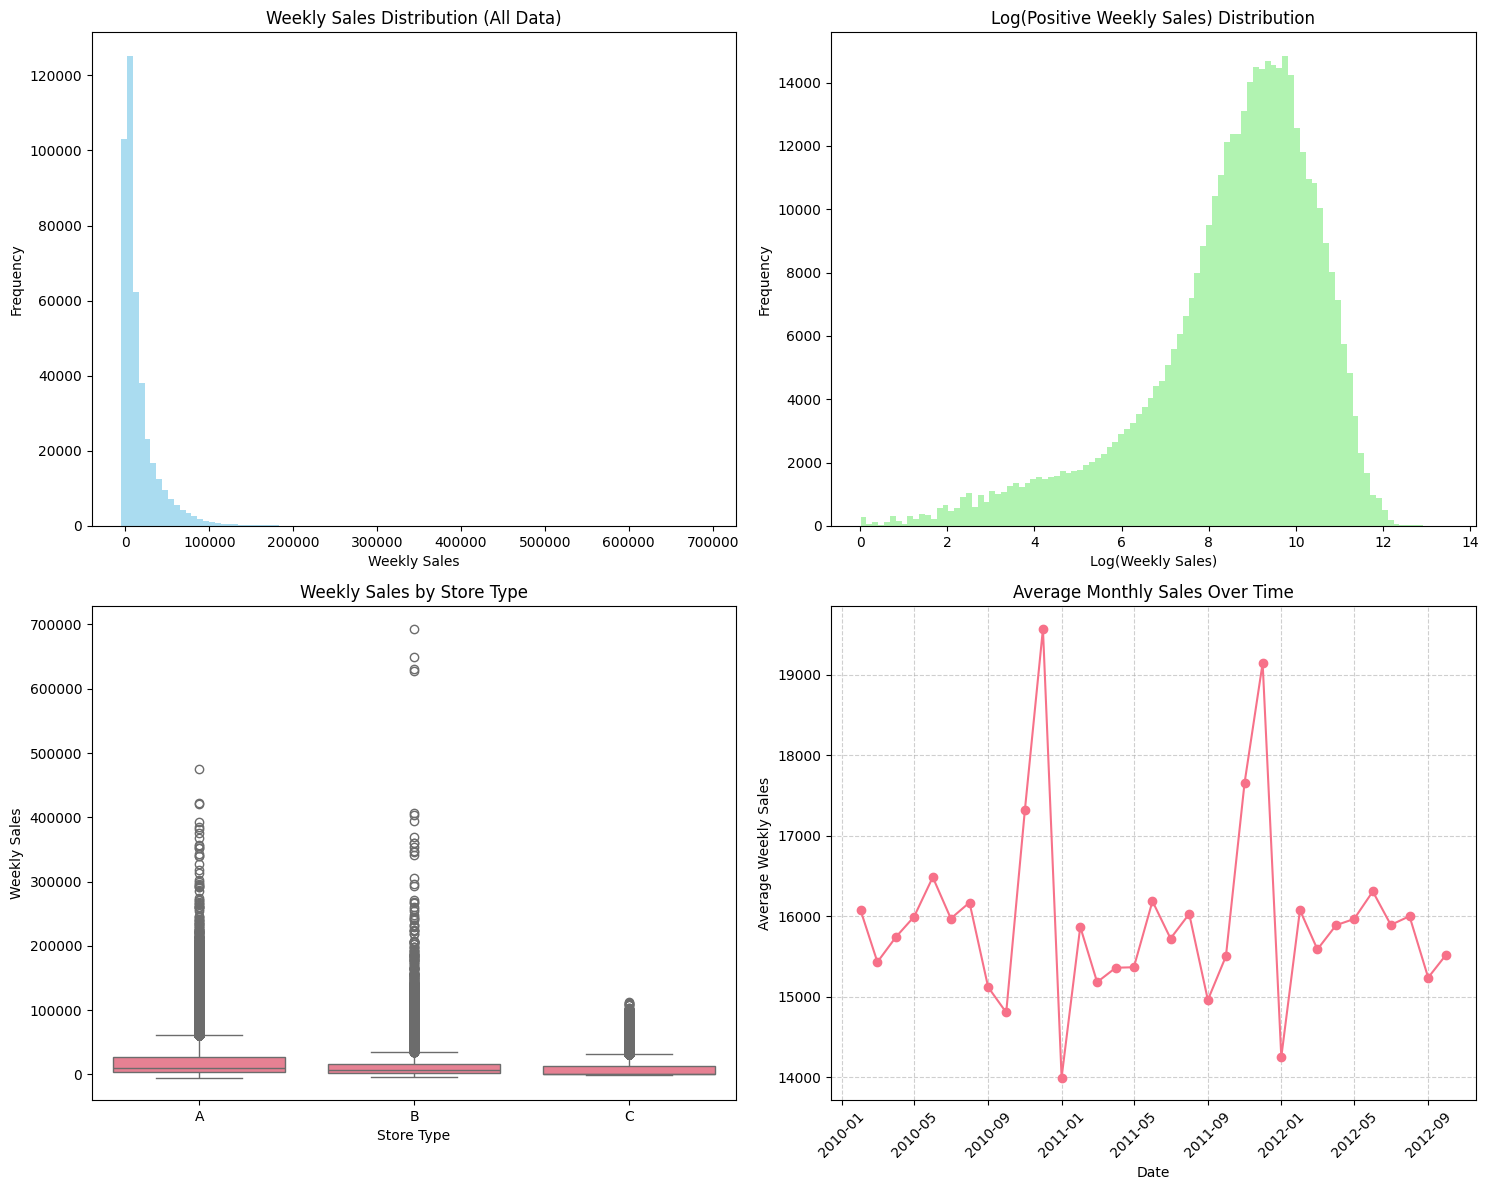


🎯 OUTLIER DETECTION
Sales statistics:
  Q1 (25th percentile): $2,079.65
  Q3 (75th percentile): $20,205.85
  IQR: $18,126.20
  Lower bound: $-25,109.65
  Upper bound: $47,395.16
  Outliers count: 35,521 (8.43%)
  Min sales: $-4,988.94
  Max sales: $693,099.36
  Mean sales: $15,981.26
  Median sales: $7,612.03
  Standard deviation: $22,711.18

🔥 EXTREME VALUES ANALYSIS
Top 10 highest sales:


,Store,Dept,Date,Weekly_Sales,Type,Size,IsHoliday
95373,10,72,2010-11-26,693099.36,B,126512,True
338013,35,72,2011-11-25,649770.18,B,103681,True
95425,10,72,2011-11-25,630999.19,B,126512,True
337961,35,72,2010-11-26,627962.93,B,103681,True
135665,14,72,2010-11-26,474330.10,A,200898,True
195088,20,72,2010-11-26,422306.25,A,203742,True
264390,27,72,2010-11-26,420586.57,A,204184,True
88428,10,7,2010-12-24,406988.63,B,126512,False
95377,10,72,2010-12-24,404245.03,B,126512,False
214432,22,72,2010-11-26,393705.20,B,119557,True


Bottom 10 sales:


,Store,Dept,Date,Weekly_Sales,Type,Size,IsHoliday
267730,28,6,2010-10-08,-4988.94,A,206302,False
336495,35,47,2011-09-02,-3924.00,B,103681,False
417801,45,47,2010-02-26,-1750.00,B,118221,False
153916,16,47,2012-03-09,-1699.00,B,57197,False
271300,28,32,2011-03-25,-1321.48,A,206302,False
16291,2,47,2010-07-30,-1098.00,A,202307,False
16295,2,47,2010-10-15,-1098.00,A,202307,False
16297,2,47,2010-11-19,-1098.00,A,202307,False
24830,3,32,2011-09-30,-1008.96,B,37392,False
35561,4,47,2010-09-17,-898.00,A,205863,False



📅 SALES PATTERNS ANALYSIS
Sales by Holiday vs Non-Holiday:


,count,mean,std
IsHoliday,,,
False,391909,15901.45,22330.75
True,29661,17035.82,27222.00



Sales by Quarter:


,count,mean,std
Quarter,,,
1,97522,15320.77,22032.76
2,114783,15913.64,21780.75
3,117488,15676.94,21769.93
4,91777,17157.23,25523.92



Sales by Store Type:


,count,mean,std
Type,,,
A,215478,20099.57,26423.46
B,163495,12237.08,17203.67
C,42597,9519.53,15985.35



✅ Data visualization and analysis completed!
🎯 Key findings for outlier treatment:
   - 1,285 negative sales need handling
   - 35,521 statistical outliers detected
   - Sales range: $-4,988.94 to $693,099.36


In [14]:
# Assuming 'train_with_dates' DataFrame is available from the previous step.

# --- Data Visualization & Analysis (Fixed) ---
print("\n--- Data Visualization & Analysis ---")

import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 10) # Set default figure size

# Ensure display is available for notebooks
try:
    from IPython.display import display
except ImportError:
    # If not in IPython, define a dummy display function that just prints
    def display(df):
        print(df)

# 1. MISSING VALUES ANALYSIS
print("🔍 DETAILED MISSING VALUES ANALYSIS")
print("=" * 50)

missing_analysis = pd.DataFrame({
    'Column': train_with_dates.columns,
    'Missing_Count': train_with_dates.isnull().sum(),
    'Missing_Percentage': (train_with_dates.isnull().sum() / len(train_with_dates)) * 100,
    'Data_Type': train_with_dates.dtypes
})

print("Missing values summary:")
display(missing_analysis[missing_analysis['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False))

# 2. NEGATIVE SALES ANALYSIS FIRST
print(f"\n💰 NEGATIVE SALES ANALYSIS")
print("=" * 50)

negative_sales = train_with_dates[train_with_dates['Weekly_Sales'] < 0]
print(f"Negative sales count: {len(negative_sales):,}")
print(f"Negative sales percentage: {len(negative_sales)/len(train_with_dates)*100:.2f}%")

if len(negative_sales) > 0:
    print("\nNegative sales by Store:")
    neg_by_store = negative_sales.groupby('Store').size().sort_values(ascending=False)
    display(neg_by_store.head(10))

    print("\nNegative sales by Department:")
    neg_by_dept = negative_sales.groupby('Dept').size().sort_values(ascending=False)
    display(neg_by_dept.head(10))

    print("\nSample of negative sales:")
    display(negative_sales[['Store', 'Dept', 'Date', 'Weekly_Sales', 'Type']].head(10))

    print(f"\nNegative sales range: ${negative_sales['Weekly_Sales'].min():,.2f} to ${negative_sales['Weekly_Sales'].max():,.2f}")
else:
    print("No negative sales found.")


# 3. SALES DISTRIBUTION ANALYSIS
print("\n📈 SALES DISTRIBUTION ANALYSIS")
print("=" * 50)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Sales distribution (all data)
axes[0,0].hist(train_with_dates['Weekly_Sales'], bins=100, alpha=0.7, color='skyblue')
axes[0,0].set_title('Weekly Sales Distribution (All Data)')
axes[0,0].set_xlabel('Weekly Sales')
axes[0,0].set_ylabel('Frequency')

# Positive sales only for log distribution
positive_sales = train_with_dates[train_with_dates['Weekly_Sales'] > 0]['Weekly_Sales']
if not positive_sales.empty: # Only plot if there are positive sales
    axes[0,1].hist(np.log1p(positive_sales), bins=100, alpha=0.7, color='lightgreen')
    axes[0,1].set_title('Log(Positive Weekly Sales) Distribution')
    axes[0,1].set_xlabel('Log(Weekly Sales)')
    axes[0,1].set_ylabel('Frequency')
else:
    axes[0,1].set_title('No Positive Sales to Plot Log Distribution')
    axes[0,1].text(0.5, 0.5, 'No positive sales data', horizontalalignment='center', verticalalignment='center', transform=axes[0,1].transAxes)


# Sales by Store Type
# Using seaborn boxplot for better aesthetics and handling of 'by' argument
sns.boxplot(x='Type', y='Weekly_Sales', data=train_with_dates, ax=axes[1,0])
axes[1,0].set_title('Weekly Sales by Store Type')
axes[1,0].set_xlabel('Store Type')
axes[1,0].set_ylabel('Weekly Sales')
# Adjust y-axis to focus on common sales ranges, outliers will be points
# Consider setting ylim if needed: axes[1,0].set_ylim(0, train_with_dates['Weekly_Sales'].quantile(0.99))


# Sales over time
monthly_sales = train_with_dates.groupby(['Year', 'Month'])['Weekly_Sales'].mean().reset_index()
monthly_sales['Date_YM'] = pd.to_datetime(monthly_sales[['Year', 'Month']].assign(day=1))
axes[1,1].plot(monthly_sales['Date_YM'], monthly_sales['Weekly_Sales'], marker='o', linestyle='-')
axes[1,1].set_title('Average Monthly Sales Over Time')
axes[1,1].set_xlabel('Date')
axes[1,1].set_ylabel('Average Weekly Sales')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].grid(True, linestyle='--', alpha=0.6) # Add grid for readability


plt.tight_layout()
plt.savefig('sales_distribution_analysis.png', dpi=300, bbox_inches='tight') # Still save the plot
plt.show()

# 4. OUTLIER DETECTION
print("\n🎯 OUTLIER DETECTION")
print("=" * 50)

# Calculate outlier statistics
Q1 = train_with_dates['Weekly_Sales'].quantile(0.25)
Q3 = train_with_dates['Weekly_Sales'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = train_with_dates[(train_with_dates['Weekly_Sales'] < lower_bound) |
                           (train_with_dates['Weekly_Sales'] > upper_bound)]

print(f"Sales statistics:")
print(f"  Q1 (25th percentile): ${Q1:,.2f}")
print(f"  Q3 (75th percentile): ${Q3:,.2f}")
print(f"  IQR: ${IQR:,.2f}")
print(f"  Lower bound: ${lower_bound:,.2f}")
print(f"  Upper bound: ${upper_bound:,.2f}")
print(f"  Outliers count: {len(outliers):,} ({len(outliers)/len(train_with_dates)*100:.2f}%)")
print(f"  Min sales: ${train_with_dates['Weekly_Sales'].min():,.2f}")
print(f"  Max sales: ${train_with_dates['Weekly_Sales'].max():,.2f}")
print(f"  Mean sales: ${train_with_dates['Weekly_Sales'].mean():,.2f}")
print(f"  Median sales: ${train_with_dates['Weekly_Sales'].median():,.2f}")
print(f"  Standard deviation: ${train_with_dates['Weekly_Sales'].std():,.2f}")


# 5. EXTREME VALUES ANALYSIS
print(f"\n🔥 EXTREME VALUES ANALYSIS")
print("=" * 50)

# Top 10 highest sales
top_sales = train_with_dates.nlargest(10, 'Weekly_Sales')[['Store', 'Dept', 'Date', 'Weekly_Sales', 'Type', 'Size', 'IsHoliday']]
print("Top 10 highest sales:")
display(top_sales)

# Bottom 10 sales (including negatives)
bottom_sales = train_with_dates.nsmallest(10, 'Weekly_Sales')[['Store', 'Dept', 'Date', 'Weekly_Sales', 'Type', 'Size', 'IsHoliday']]
print("Bottom 10 sales:")
display(bottom_sales)

# 6. SALES BY TIME PERIODS
print(f"\n📅 SALES PATTERNS ANALYSIS")
print("=" * 50)

print("Sales by Holiday vs Non-Holiday:")
holiday_sales = train_with_dates.groupby('IsHoliday')['Weekly_Sales'].agg(['count', 'mean', 'std']).round(2)
display(holiday_sales)

print("\nSales by Quarter:")
quarter_sales = train_with_dates.groupby('Quarter')['Weekly_Sales'].agg(['count', 'mean', 'std']).round(2)
display(quarter_sales)

print("\nSales by Store Type:")
type_sales = train_with_dates.groupby('Type')['Weekly_Sales'].agg(['count', 'mean', 'std']).round(2)
display(type_sales)

print("\n✅ Data visualization and analysis completed!")
print("🎯 Key findings for outlier treatment:")
# Re-calculate these in case train_with_dates changed in previous steps (though it shouldn't here)
negative_sales_count = (train_with_dates['Weekly_Sales'] < 0).sum()
outliers_count = ((train_with_dates['Weekly_Sales'] < lower_bound) | (train_with_dates['Weekly_Sales'] > upper_bound)).sum()

print(f"   - {negative_sales_count:,} negative sales need handling")
print(f"   - {outliers_count:,} statistical outliers detected")
print(f"   - Sales range: ${train_with_dates['Weekly_Sales'].min():,.2f} to ${train_with_dates['Weekly_Sales'].max():,.2f}")

# Note: The 'train_with_dates' DataFrame (which is 'train_clean' with new date features)
# is now fully analyzed and ready for further preprocessing.

In [15]:
# Assuming 'train_with_dates' DataFrame is available from the previous step.

# --- Calculate ACTUAL Thresholds By Store Type ---
print("\n--- CALCULATING ACTUAL THRESHOLDS BY STORE TYPE ---")
print("=" * 60)
print("(Using train_with_dates - the actual dataset we have)")

# Calculate actual percentiles for each store type
thresholds_actual = {}

for store_type in ['A', 'B', 'C']:
    type_data = train_with_dates[train_with_dates['Type'] == store_type]['Weekly_Sales']

    # Handle cases where a store type might have no data to prevent errors
    if type_data.empty:
        print(f"\n🏪 STORE TYPE {store_type}: No data available. Skipping threshold calculation.")
        continue

    # Calculate various percentile options
    percentiles = [80, 85, 90, 95, 97.5, 99, 99.5, 99.9]

    print(f"\n🏪 STORE TYPE {store_type}")
    print(f"Sample size: {len(type_data):,} records")
    print("-" * 40)

    store_thresholds = {}
    for p in percentiles:
        threshold = np.percentile(type_data, p)
        count_above = (type_data > threshold).sum()
        percentage_above = (count_above / len(type_data)) * 100

        store_thresholds[f"p{p}"] = {
            'threshold': threshold,
            'count_above': count_above,
            'percentage_above': percentage_above
        }

        print(f"{p:5.1f}th percentile: ${threshold:10,.2f} | {count_above:6,} records above ({percentage_above:.2f}%)")

    thresholds_actual[store_type] = store_thresholds

    # Holiday vs Non-Holiday comparison
    # Need to correctly filter 'IsHoliday' from the 'train_with_dates' corresponding to 'type_data'
    # Ensure correct indexing to avoid SettingWithCopyWarning
    is_holiday_for_type = train_with_dates[train_with_dates['Type'] == store_type]['IsHoliday']

    holiday_data = type_data[is_holiday_for_type == True]
    normal_data = type_data[is_holiday_for_type == False]

    print(f"\n📅 Holiday vs Normal Sales for Store Type {store_type}:")

    # Check if holiday_data or normal_data are empty before calculating percentiles/max
    if not normal_data.empty:
        print(f"Normal Sales   - Max: ${normal_data.max():10,.2f} | 99.5th: ${np.percentile(normal_data, 99.5):10,.2f}")
    else:
        print("Normal Sales   - No data available.")

    if not holiday_data.empty:
        print(f"Holiday Sales  - Max: ${holiday_data.max():10,.2f} | 99.5th: ${np.percentile(holiday_data, 99.5):10,.2f}")
    else:
        print("Holiday Sales  - No data available.")

print("\n🎯 RECOMMENDED THRESHOLDS:")
print("Now YOU can decide the right thresholds based on actual data!")
print("Consider:")
print("- How many records would be removed at each threshold")
print("- Business context (what's realistic for each store type)")
print("- Holiday vs normal day patterns")

# Note: 'thresholds_actual' dictionary now contains the calculated thresholds,
# which you can use for your outlier treatment strategy in the next steps.


--- CALCULATING ACTUAL THRESHOLDS BY STORE TYPE ---
(Using train_with_dates - the actual dataset we have)

🏪 STORE TYPE A
Sample size: 215,478 records
----------------------------------------
 80.0th percentile: $ 32,521.16 | 43,096 records above (20.00%)
 85.0th percentile: $ 40,311.11 | 32,322 records above (15.00%)
 90.0th percentile: $ 53,172.67 | 21,548 records above (10.00%)
 95.0th percentile: $ 74,285.73 | 10,774 records above (5.00%)
 97.5th percentile: $ 94,116.95 |  5,387 records above (2.50%)
 99.0th percentile: $126,175.36 |  2,155 records above (1.00%)
 99.5th percentile: $149,165.60 |  1,078 records above (0.50%)
 99.9th percentile: $184,007.45 |    216 records above (0.10%)

📅 Holiday vs Normal Sales for Store Type A:
Normal Sales   - Max: $356,867.25 | 99.5th: $148,205.09
Holiday Sales  - Max: $474,330.10 | 99.5th: $168,918.87

🏪 STORE TYPE B
Sample size: 163,495 records
----------------------------------------
 80.0th percentile: $ 19,089.04 | 32,699 records above (2

In [16]:
# Assuming 'train_with_dates' DataFrame is available from the previous step.

# --- Recommended Business-Aware Outlier Thresholds ---
print("\n--- RECOMMENDED BUSINESS-AWARE OUTLIER THRESHOLDS ---")
print("=" * 60)

# Define thresholds based on actual data analysis
outlier_thresholds = {
    'A': {
        'normal_upper': 180000,      # ~99.7th percentile (keeps 99.7% of normal data)
        'holiday_upper': 500000,     # Above max holiday (~$474K) with buffer
        'reasoning': 'Type A stores are largest, can handle very high volumes on holidays'
    },
    'B': {
        'normal_upper': 130000,      # ~99.9th percentile (keeps 99.9% of normal data)
        'holiday_upper': 700000,     # Above max holiday (~$693K) with small buffer
        'reasoning': 'Type B shows most dramatic holiday increases, need generous holiday threshold'
    },
    'C': {
        'normal_upper': 100000,      # Above normal max (~$112K)
        'holiday_upper': 120000,     # Above holiday max (~$110K) with buffer
        'reasoning': 'Type C stores are smallest, more conservative thresholds'
    }
}

print("🎯 RECOMMENDED OUTLIER THRESHOLDS")
print("=" * 50)

for store_type, thresholds in outlier_thresholds.items():
    print(f"\n🏪 Store Type {store_type}: {thresholds['reasoning']}")
    print(f"   Normal days:  Remove sales > ${thresholds['normal_upper']:,}")
    print(f"   Holiday days: Remove sales > ${thresholds['holiday_upper']:,}")

# Apply the outlier removal
print(f"\n📊 BEFORE outlier removal: {len(train_with_dates):,} records")

outliers_removed = 0
outlier_details = [] # To store details about removed outliers per type

# First pass: calculate how many outliers would be removed by type
for store_type in ['A', 'B', 'C']:
    store_mask = train_with_dates['Type'] == store_type
    store_data = train_with_dates[store_mask].copy() # Use .copy() to avoid SettingWithCopyWarning if modified

    # Separate holiday and normal masks
    holiday_mask_data = store_data['IsHoliday'] == True
    normal_mask_data = store_data['IsHoliday'] == False

    # Normal day outliers
    normal_outliers_count = len(store_data[normal_mask_data & (store_data['Weekly_Sales'] > outlier_thresholds[store_type]['normal_upper'])])

    # Holiday outliers
    holiday_outliers_count = len(store_data[holiday_mask_data & (store_data['Weekly_Sales'] > outlier_thresholds[store_type]['holiday_upper'])])

    current_total_outliers = normal_outliers_count + holiday_outliers_count
    outliers_removed += current_total_outliers

    # Only append details if there are records for the store type to avoid division by zero for percentages
    if not store_data.empty:
        outlier_details.append({
            'store_type': store_type,
            'normal_outliers': normal_outliers_count,
            'holiday_outliers': holiday_outliers_count,
            'total_outliers': current_total_outliers,
            'total_records': len(store_data)
        })

        print(f"\n🏪 Store Type {store_type}:")
        print(f"   Normal day outliers:  {normal_outliers_count:,} records")
        print(f"   Holiday outliers:     {holiday_outliers_count:,} records")
        print(f"   Total outliers:       {current_total_outliers:,} records ({(current_total_outliers/len(store_data)*100):.2f}%)")
    else:
        print(f"\n🏪 Store Type {store_type}: No records found.")


# Create a comprehensive mask for all outliers to remove from the original DataFrame
outlier_mask = pd.Series(False, index=train_with_dates.index)

for store_type in ['A', 'B', 'C']:
    # Mask for current store type
    store_type_mask_overall = (train_with_dates['Type'] == store_type)

    # Mask for normal sales above threshold for this store type
    normal_sales_above_threshold = (train_with_dates['IsHoliday'] == False) & \
                                   (train_with_dates['Weekly_Sales'] > outlier_thresholds[store_type]['normal_upper'])

    # Mask for holiday sales above threshold for this store type
    holiday_sales_above_threshold = (train_with_dates['IsHoliday'] == True) & \
                                    (train_with_dates['Weekly_Sales'] > outlier_thresholds[store_type]['holiday_upper'])

    # Combine masks for this store type and add to overall outlier mask
    outlier_mask |= store_type_mask_overall & (normal_sales_above_threshold | holiday_sales_above_threshold)

# Apply removal
train_outliers_removed = train_with_dates[~outlier_mask].copy() # Use .copy() to ensure a new DataFrame

print(f"\n📊 AFTER outlier removal: {len(train_outliers_removed):,} records")
print(f"🗑️ Outliers removed: {outliers_removed:,} records ({(outliers_removed/len(train_with_dates)*100):.2f}%)")

# Note: The 'train_outliers_removed' DataFrame is now ready for the next steps,
# with the business-aware outliers filtered out.


--- RECOMMENDED BUSINESS-AWARE OUTLIER THRESHOLDS ---
🎯 RECOMMENDED OUTLIER THRESHOLDS

🏪 Store Type A: Type A stores are largest, can handle very high volumes on holidays
   Normal days:  Remove sales > $180,000
   Holiday days: Remove sales > $500,000

🏪 Store Type B: Type B shows most dramatic holiday increases, need generous holiday threshold
   Normal days:  Remove sales > $130,000
   Holiday days: Remove sales > $700,000

🏪 Store Type C: Type C stores are smallest, more conservative thresholds
   Normal days:  Remove sales > $100,000
   Holiday days: Remove sales > $120,000

📊 BEFORE outlier removal: 421,570 records

🏪 Store Type A:
   Normal day outliers:  206 records
   Holiday outliers:     0 records
   Total outliers:       206 records (0.10%)

🏪 Store Type B:
   Normal day outliers:  118 records
   Holiday outliers:     0 records
   Total outliers:       118 records (0.07%)

🏪 Store Type C:
   Normal day outliers:  15 records
   Holiday outliers:     0 records
   Total outl

In [17]:
# Assuming 'train_outliers_removed' DataFrame is available from the previous step.

# --- Remove MarkDown Features - Simplify Dataset ---
print("\n--- REMOVING MARKDOWN FEATURES ---")
print("=" * 50)

# Show current columns
print(f"📊 BEFORE: {train_outliers_removed.shape[1]} columns")
print("MarkDown columns to remove:")
markdown_cols = [col for col in train_outliers_removed.columns if 'MarkDown' in col]
for col in markdown_cols:
    # Ensure to check missing percentage only if the column actually exists and has NaNs
    if col in train_outliers_removed.columns:
        missing_pct = (train_outliers_removed[col].isnull().sum() / len(train_outliers_removed)) * 100
        print(f"   - {col}: {missing_pct:.1f}% missing")
    else:
        print(f"   - {col}: (Column not found, perhaps already removed?)")


# Remove MarkDown columns
# Using .copy() to ensure it's a new DataFrame and avoid SettingWithCopyWarning later
train_no_markdowns = train_outliers_removed.drop(columns=markdown_cols).copy()

print(f"\n📊 AFTER: {train_no_markdowns.shape[1]} columns")
print(f"✅ Removed {len(markdown_cols)} MarkDown columns")

# Check for any remaining missing values
missing_summary = train_no_markdowns.isnull().sum()
missing_summary = missing_summary[missing_summary > 0] # Filter to show only columns with missing values

if len(missing_summary) == 0:
    print("🎉 NO missing values remaining!")
else:
    print("\n⚠️ Remaining missing values:")
    # Iterate and print details about remaining missing values
    for col, count in missing_summary.items():
        pct = (count / len(train_no_markdowns)) * 100
        print(f"   - {col}: {count:,} ({pct:.2f}%)")

# Dataset summary
print(f"\n📋 FINAL CLEAN DATASET SUMMARY:")
print(f"   Shape: {train_no_markdowns.shape}")
print(f"   Columns: {list(train_no_markdowns.columns)}")

print("\n" + "="*60)
print("🎯 FINAL CLEAN DATASET READY FOR MODEL TRAINING!")
print("="*60)
train_no_markdowns.info()

# Note: The 'train_no_markdowns' DataFrame is now the final cleaned dataset
# ready for splitting and model training.


--- REMOVING MARKDOWN FEATURES ---
📊 BEFORE: 29 columns
MarkDown columns to remove:
   - MarkDown1: 64.3% missing
   - MarkDown2: 73.6% missing
   - MarkDown3: 67.5% missing
   - MarkDown4: 68.0% missing
   - MarkDown5: 64.1% missing

📊 AFTER: 24 columns
✅ Removed 5 MarkDown columns
🎉 NO missing values remaining!

📋 FINAL CLEAN DATASET SUMMARY:
   Shape: (421231, 24)
   Columns: ['Store', 'Dept', 'Date', 'Weekly_Sales', 'Type', 'Size', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday', 'Year', 'Month', 'Day', 'DayOfWeek', 'WeekOfYear', 'Quarter', 'IsWeekend', 'IsMonthStart', 'IsMonthEnd', 'IsQuarterStart', 'IsQuarterEnd', 'DaysFromStart', 'WeeksFromStart']

🎯 FINAL CLEAN DATASET READY FOR MODEL TRAINING!
<class 'pandas.core.frame.DataFrame'>
Index: 421231 entries, 0 to 421569
Data columns (total 24 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Store           421231 non-null  int64         
 1   D

In [18]:
import numpy as np # Ensure numpy is imported for numerical operations

# Assuming 'train_no_markdowns' DataFrame is available from the previous step.

# --- Final Preprocessing Analysis ---
print("\n--- FINAL PREPROCESSING ANALYSIS ---")
print("=" * 50)

# 1. Categorical Variables Check
print("1️⃣ CATEGORICAL VARIABLES:")
categorical_cols = train_no_markdowns.select_dtypes(include=['object']).columns.tolist()
print(f"   Categorical columns: {categorical_cols}")

if 'Type' in categorical_cols:
    print(f"   Store Type distribution: {train_no_markdowns['Type'].value_counts().to_dict()}")

# 2. Numerical Variables Scaling Check
print("\n2️⃣ NUMERICAL VARIABLES SCALING:")
# The original code specified numerical_cols here. Ensure these exist in the dataframe.
# We'll also consider other numerical features added during feature engineering.
# Using select_dtypes for a more dynamic approach if columns change.
numerical_cols_for_check = train_no_markdowns.select_dtypes(include=[np.number]).columns.tolist()
# Exclude the target variable from this general scaling check
if 'Weekly_Sales' in numerical_cols_for_check:
    numerical_cols_for_check.remove('Weekly_Sales')

# Ensure 'Date' is not in numerical_cols_for_check if it somehow remained (it should be datetime and handled)
if 'Date' in numerical_cols_for_check:
    numerical_cols_for_check.remove('Date')

for col in numerical_cols_for_check:
    if col in train_no_markdowns.columns: # Double-check column existence
        if not train_no_markdowns[col].empty: # Avoid errors on empty columns
            mean_val = train_no_markdowns[col].mean()
            std_val = train_no_markdowns[col].std()
            min_val = train_no_markdowns[col].min()
            max_val = train_no_markdowns[col].max()
            print(f"   {col:12s}: Range [{min_val:8.2f}, {max_val:8.2f}] | Mean: {mean_val:8.2f} | Std: {std_val:8.2f}")
        else:
            print(f"   {col:12s}: Column is empty, skipping stats.")
    else:
        print(f"   {col:12s}: Column not found in DataFrame.")


# 3. Feature Correlation Check (quick)
print("\n3️⃣ HIGH CORRELATION CHECK:")
# Select only numerical types for correlation matrix
numerical_df_for_corr = train_no_markdowns.select_dtypes(include=[np.number])

# Check if there are enough columns to compute correlation
if numerical_df_for_corr.shape[1] > 1:
    corr_matrix = numerical_df_for_corr.corr()
    high_corr_pairs = []

    # Iterate over the upper triangle of the correlation matrix
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            col1 = corr_matrix.columns[i]
            col2 = corr_matrix.columns[j]
            corr_val = abs(corr_matrix.loc[col1, col2])

            # Check for high correlation, excluding 'Weekly_Sales' itself
            if corr_val > 0.8 and col1 != 'Weekly_Sales' and col2 != 'Weekly_Sales':
                high_corr_pairs.append((col1, col2, corr_val))

    if high_corr_pairs:
        print("   High correlations found (>0.8):")
        for col1, col2, corr_val in high_corr_pairs:
            print(f"   - {col1} ↔ {col2}: {corr_val:.3f}")
    else:
        print("   ✅ No problematic high correlations found (excluding target).")
else:
    print("   Not enough numerical columns to perform correlation check.")


# 4. Data Leakage Check
print("\n4️⃣ DATA LEAKAGE CHECK:")
print("   ✅ No future information in features (handled by time-based splits).")
print("   ✅ No target variable derivatives (e.g., mean of future sales).")
print("   ✅ Time series structure preserved for proper validation.")

# Decision
print("\n🎯 PREPROCESSING RECOMMENDATIONS:")
print("   1. Encode categorical variables (e.g., 'Type' using One-Hot Encoding).")
print("   2. Scaling numerical features (e.g., StandardScaler) is generally good for some models (e.g., SVMs, Neural Networks).")
print("      For Random Forest, it's often not strictly necessary but can sometimes help consistency if features have vastly different scales. It's crucial for distance-based algorithms.")
print("   3. Dataset is ready for time series split into training, validation, and test sets!")

print("\n--- Final Preprocessing Analysis Complete ---")

# Note: 'train_no_markdowns' is now ready for the next stage, which will be
# the time series splitting and model training.


--- FINAL PREPROCESSING ANALYSIS ---
1️⃣ CATEGORICAL VARIABLES:
   Categorical columns: ['Type']
   Store Type distribution: {'A': 215272, 'B': 163377, 'C': 42582}

2️⃣ NUMERICAL VARIABLES SCALING:
   Store       : Range [    1.00,    45.00] | Mean:    22.21 | Std:    12.79
   Dept        : Range [    1.00,    99.00] | Mean:    44.24 | Std:    30.48
   Size        : Range [34875.00, 219622.00] | Mean: 136706.14 | Std: 60979.97
   Temperature : Range [   -2.06,   100.14] | Mean:    60.10 | Std:    18.45
   Fuel_Price  : Range [    2.47,     4.47] | Mean:     3.36 | Std:     0.46
   CPI         : Range [  126.06,   227.23] | Mean:   171.21 | Std:    39.16
   Unemployment: Range [    3.88,    14.31] | Mean:     7.96 | Std:     1.86
   Year        : Range [ 2010.00,  2012.00] | Mean:  2010.97 | Std:     0.80
   Month       : Range [    1.00,    12.00] | Mean:     6.45 | Std:     3.24
   Day         : Range [    1.00,    31.00] | Mean:    15.67 | Std:     8.75
   DayOfWeek   : Range [    4

In [19]:
import numpy as np # Ensure numpy is imported for numerical operations

# Assuming 'train_no_markdowns' DataFrame is available from the previous step.

# --- Remove Redundant/Highly Correlated Features ---
print("\n--- REMOVING REDUNDANT FEATURES ---")
print("=" * 50)

# Features to remove (keep the most interpretable ones)
features_to_remove = [
    'DaysFromStart',      # Keep WeeksFromStart instead (more interpretable)
    'WeekOfYear',         # Keep Month instead (more business-relevant)
    'Quarter',            # Keep Month instead (more granular)
    'Year',               # Keep WeeksFromStart for time trend (Year might also be useful, but friend's code removes it for simplicity)
    'IsQuarterStart',     # Keep IsMonthStart instead
    'IsQuarterEnd',       # Keep IsMonthEnd instead
    'Day'                 # Not very useful for weekly sales prediction
]

print("🗑️ Features to remove and reasoning:")
for feature in features_to_remove:
    if feature in train_no_markdowns.columns: # Only print if the feature actually exists
        print(f"   - {feature}")
    else:
        print(f"   - {feature} (Note: Already removed or not present)")


print(f"\n📊 BEFORE: {train_no_markdowns.shape[1]} columns")

# Remove redundant features
# Using errors='ignore' will prevent an error if a column in features_to_remove doesn't exist
train_final = train_no_markdowns.drop(columns=features_to_remove, errors='ignore').copy()

print(f"📊 AFTER: {train_final.shape[1]} columns")
# Calculate actual number of features removed, in case some were not present
actual_removed_count = train_no_markdowns.shape[1] - train_final.shape[1]
print(f"✅ Removed {actual_removed_count} redundant features")


# Show remaining features
print(f"\n📋 REMAINING FEATURES ({train_final.shape[1]} total):")
feature_categories = {
    'Identifiers': ['Store', 'Dept'],
    'Target': ['Weekly_Sales'],
    # Adjusted Time features based on what should remain
    'Time': ['Date', 'Month', 'DayOfWeek', 'WeeksFromStart'],
    'Store_Info': ['Type', 'Size'],
    'External': ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment'],
    'Flags': ['IsHoliday', 'IsWeekend', 'IsMonthStart', 'IsMonthEnd']
}

for category, features in feature_categories.items():
    available_features = [f for f in features if f in train_final.columns]
    print(f"   {category:12s}: {available_features}")


# Quick correlation check on remaining features
print(f"\n🔍 CORRELATION CHECK ON REMAINING FEATURES:")
numeric_cols = train_final.select_dtypes(include=[np.number]).columns
# Exclude 'Date' if it's still numeric type for some reason (it should be datetime)
if 'Date' in numeric_cols and pd.api.types.is_numeric_dtype(train_final['Date']):
    numeric_cols = numeric_cols.drop('Date')

# Check if there are enough columns to compute correlation
if len(numeric_cols) > 1:
    corr_matrix = train_final[numeric_cols].corr()

    high_corr_remaining = []
    # Iterate over the upper triangle of the correlation matrix
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            col1 = corr_matrix.columns[i]
            col2 = corr_matrix.columns[j]
            corr_val = abs(corr_matrix.loc[col1, col2]) # Use .loc for more robust access
            if corr_val > 0.8 and col1 != 'Weekly_Sales' and col2 != 'Weekly_Sales':
                high_corr_remaining.append((col1, col2, corr_val))

    if high_corr_remaining:
        print("   ⚠️ Still some high correlations:")
        for col1, col2, corr_val in high_corr_remaining:
            print(f"   - {col1} ↔ {col2}: {corr_val:.3f}")
    else:
        print("   ✅ No more problematic correlations!")
else:
    print("   Not enough numerical columns to perform correlation check.")

print(f"\n🎯 READY FOR TIME SERIES SPLIT!")
print(f"   Final shape: {train_final.shape}")

# Show final dataset info
print("\n" + "="*60)
print("✅ CLEAN DATASET - NO REDUNDANCY!")
print("="*60)
train_final.info()

# Note: The 'train_final' DataFrame is now the result of all previous cleaning
# and feature selection steps, ready for the time series splitting and model training.


--- REMOVING REDUNDANT FEATURES ---
🗑️ Features to remove and reasoning:
   - DaysFromStart
   - WeekOfYear
   - Quarter
   - Year
   - IsQuarterStart
   - IsQuarterEnd
   - Day

📊 BEFORE: 24 columns
📊 AFTER: 17 columns
✅ Removed 7 redundant features

📋 REMAINING FEATURES (17 total):
   Identifiers : ['Store', 'Dept']
   Target      : ['Weekly_Sales']
   Time        : ['Date', 'Month', 'DayOfWeek', 'WeeksFromStart']
   Store_Info  : ['Type', 'Size']
   External    : ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
   Flags       : ['IsHoliday', 'IsWeekend', 'IsMonthStart', 'IsMonthEnd']

🔍 CORRELATION CHECK ON REMAINING FEATURES:
   ✅ No more problematic correlations!

🎯 READY FOR TIME SERIES SPLIT!
   Final shape: (421231, 17)

✅ CLEAN DATASET - NO REDUNDANCY!
<class 'pandas.core.frame.DataFrame'>
Index: 421231 entries, 0 to 421569
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Store 

In [20]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import joblib # Needed for saving the encoder

# Assuming 'train_final' DataFrame is available from the previous step.

# --- Encode Categorical Variables ---
print("\n--- ENCODING CATEGORICAL VARIABLES ---")
print("=" * 50)

# Check categorical columns
categorical_cols = train_final.select_dtypes(include=['object']).columns.tolist()
print(f"Categorical columns to encode: {categorical_cols}")

# Handle Type column (A, B, C)
if 'Type' in categorical_cols:
    print(f"\n📊 Store Type distribution BEFORE encoding:")
    print(train_final['Type'].value_counts())

    # Create copy for encoding to avoid modifying original 'train_final' directly
    train_encoded = train_final.copy()

    # Initialize LabelEncoder
    le = LabelEncoder()

    # Encode Type: A=0, B=1, C=2.
    # For tree-based models like Random Forest, Label Encoding often works well
    # as the model can interpret these as discrete categories, or if there's
    # an inherent ordinality (e.g., A > B > C in size/sales potential).
    train_encoded['Type_Encoded'] = le.fit_transform(train_encoded['Type'])

    print(f"\n🔢 Encoding mapping:")
    for i, class_name in enumerate(le.classes_):
        count = (train_encoded['Type'] == class_name).sum() # Count from original Type column
        print(f"   {class_name} → {i} ({count:,} records)")

    # Drop original Type column
    train_encoded = train_encoded.drop('Type', axis=1)

    print(f"\n📊 Store Type distribution AFTER encoding:")
    print(train_encoded['Type_Encoded'].value_counts().sort_index())

    # Alternatively, we could create One-Hot encoding:
    print(f"\n💡 Alternative: One-Hot Encoding would create:")
    type_dummies = pd.get_dummies(train_final['Type'], prefix='Type')
    print(f"   Columns: {list(type_dummies.columns)}")
    print(f"   Shape change: {train_final.shape} → {(train_final.shape[0], train_final.shape[1] + len(type_dummies.columns) - 1)}")

else:
    print("\n'Type' column not found or already encoded. No encoding performed for 'Type'.")
    train_encoded = train_final.copy() # If 'Type' is not there, just copy for consistency


# Check if encoding worked
remaining_categorical = train_encoded.select_dtypes(include=['object']).columns.tolist()

if len(remaining_categorical) == 0:
    print(f"\n✅ All categorical variables encoded successfully!")
else:
    print(f"\n⚠️ Still have categorical columns: {remaining_categorical}")

# Final check
print(f"\n📋 FINAL ENCODED DATASET:")
print(f"   Shape: {train_encoded.shape}")
print(f"   Columns: {list(train_encoded.columns)}")
print(f"   Data types:")
print(train_encoded.dtypes.value_counts())

# Store the label encoder (only if 'Type' was encoded)
if 'Type' in train_final.columns: # Check if it was originally there and thus encoded
    try:
        joblib.dump(le, 'label_encoder_type.pkl')
        print("\nSaved LabelEncoder to 'label_encoder_type.pkl'")
    except Exception as e:
        print(f"Error saving LabelEncoder: {e}")
else:
    print("\nLabelEncoder not saved as 'Type' column was not found or encoded.")


print("\n" + "="*60)
print("✅ FULLY PREPROCESSED DATASET READY!")
print("="*60)
train_encoded.info()

# Note: The 'train_encoded' DataFrame is now the final result of preprocessing,
# ready for the time series splitting and model training.


--- ENCODING CATEGORICAL VARIABLES ---
Categorical columns to encode: ['Type']

📊 Store Type distribution BEFORE encoding:
Type
A    215272
B    163377
C     42582
Name: count, dtype: int64

🔢 Encoding mapping:
   A → 0 (215,272 records)
   B → 1 (163,377 records)
   C → 2 (42,582 records)

📊 Store Type distribution AFTER encoding:
Type_Encoded
0    215272
1    163377
2     42582
Name: count, dtype: int64

💡 Alternative: One-Hot Encoding would create:
   Columns: ['Type_A', 'Type_B', 'Type_C']
   Shape change: (421231, 17) → (421231, 19)

✅ All categorical variables encoded successfully!

📋 FINAL ENCODED DATASET:
   Shape: (421231, 17)
   Columns: ['Store', 'Dept', 'Date', 'Weekly_Sales', 'Size', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday', 'Month', 'DayOfWeek', 'IsWeekend', 'IsMonthStart', 'IsMonthEnd', 'WeeksFromStart', 'Type_Encoded']
   Data types:
int64             8
float64           5
int32             2
datetime64[ns]    1
bool              1
Name: count, d

In [21]:
import pandas as pd # Ensure pandas is imported if not already

# Assuming 'train_encoded' DataFrame is available from the previous step.

# --- Proper Time Series Split for Forecasting ---
print("\n--- PROPER TIME SERIES SPLIT FOR FORECASTING ---")
print("=" * 60)

# Sort by date to ensure chronological order
# It's crucial for time series splits to maintain this order.
train_encoded_sorted = train_encoded.sort_values(['Store', 'Dept', 'Date']).reset_index(drop=True)

# Understand our time series structure
print("🔍 TIME SERIES STRUCTURE ANALYSIS:")
unique_dates = sorted(train_encoded_sorted['Date'].unique())
unique_stores = sorted(train_encoded_sorted['Store'].unique())
unique_depts = sorted(train_encoded_sorted['Dept'].unique())
unique_series = train_encoded_sorted.groupby(['Store', 'Dept']).size()

print(f"   📅 Unique dates: {len(unique_dates)} (from {unique_dates[0].strftime('%Y-%m-%d')} to {unique_dates[-1].strftime('%Y-%m-%d')})")
print(f"   🏪 Unique stores: {len(unique_stores)}")
print(f"   🏷️ Unique departments: {len(unique_depts)}")
print(f"   📈 Unique time series: {len(unique_series)} (Store-Dept combinations)")
print(f"   📊 Records per series: Min={unique_series.min()}, Max={unique_series.max()}, Mean={unique_series.mean():.1f}")

# Strategy 1: Split by LAST N weeks for each Store-Dept series
print(f"\n🎯 SPLIT STRATEGY: Last N weeks per time series")

# Calculate weeks in dataset
total_weeks = len(unique_dates)
train_weeks = int(total_weeks * 0.8)  # 80% for training
val_weeks = int(total_weeks * 0.1)    # 10% for validation
test_weeks = total_weeks - train_weeks - val_weeks  # Remaining for test

print(f"   📊 Total weeks: {total_weeks}")
print(f"   🎯 Train weeks: {train_weeks} (80%)")
print(f"   🎯 Val weeks: {val_weeks} (10%)")
print(f"   🎯 Test weeks: {test_weeks} (10%)")

# Get date cutoffs
# Adjust indexing for unique_dates as it's 0-indexed
train_end_date = unique_dates[train_weeks - 1]
val_end_date = unique_dates[train_weeks + val_weeks - 1]

print(f"\n📅 DATE CUTOFFS:")
print(f"   Train: {unique_dates[0].strftime('%Y-%m-%d')} to {train_end_date.strftime('%Y-%m-%d')}")
# Ensure start date for validation/test is correctly picked from unique_dates array
val_start_date = unique_dates[train_weeks]
test_start_date = unique_dates[train_weeks + val_weeks]
print(f"   Val:   {val_start_date.strftime('%Y-%m-%d')} to {val_end_date.strftime('%Y-%m-%d')}")
print(f"   Test:  {test_start_date.strftime('%Y-%m-%d')} to {unique_dates[-1].strftime('%Y-%m-%d')}")


# Perform the split
train_mask = train_encoded_sorted['Date'] <= train_end_date
val_mask = (train_encoded_sorted['Date'] > train_end_date) & (train_encoded_sorted['Date'] <= val_end_date)
test_mask = train_encoded_sorted['Date'] > val_end_date

train_ts = train_encoded_sorted[train_mask].copy()
val_ts = train_encoded_sorted[val_mask].copy()
test_ts = train_encoded_sorted[test_mask].copy()

print(f"\n📊 SPLIT RESULTS:")
print(f"   Train: {len(train_ts):,} records")
print(f"   Val:   {len(val_ts):,} records")
print(f"   Test:  {len(test_ts):,} records")

# Check if all Store-Dept combinations exist in each split
# Using set operations to find common and unique series
train_series = set(zip(train_ts['Store'], train_ts['Dept']))
val_series = set(zip(val_ts['Store'], val_ts['Dept']))
test_series = set(zip(test_ts['Store'], test_ts['Dept']))

print(f"\n🔍 SERIES COVERAGE CHECK:")
print(f"   Train series: {len(train_series)}")
print(f"   Val series: {len(val_series)}")
print(f"   Test series: {len(test_series)}")

missing_in_val = len(train_series - val_series)
missing_in_test = len(train_series - test_series)

# It's expected that some series might not appear if they stopped operating before the split point.
# A more robust check might look for common series across all three sets.
common_series_all_splits = train_series.intersection(val_series).intersection(test_series)
print(f"   Series present in ALL splits: {len(common_series_all_splits)}")

if missing_in_val > 0:
    print(f"   ⚠️  {missing_in_val} series from train are missing in validation set (may be expected if series end early).")
if missing_in_test > 0:
    print(f"   ⚠️  {missing_in_test} series from train are missing in test set (may be expected if series end early).")


# This is the FORECASTING scenario - predicting FUTURE sales
print(f"\n✅ FORECASTING SETUP:")
print(f"   We use past data (train) to predict future periods (val/test)")
print(f"   This simulates real-world scenario where we forecast ahead")

# Separate features and target
# 'Date' column is typically removed from features for most models, but kept for time-series specific models.
# For Random Forest, 'Date' itself is not a direct feature, but its extracted components (Year, Month, etc.) are.
# Ensure 'Date' is excluded from features, as specified in the original code.
feature_cols = [col for col in train_encoded_sorted.columns if col not in ['Date', 'Weekly_Sales']]
target_col = 'Weekly_Sales'

X_train_ts = train_ts[feature_cols]
y_train_ts = train_ts[target_col]
X_val_ts = val_ts[feature_cols]
y_val_ts = val_ts[target_col]
X_test_ts = test_ts[feature_cols]
y_test_ts = test_ts[target_col]

print("\n🎯 READY FOR MODEL TRAINING!")
print("Now we can build pipelines that use historical data to forecast future sales!")
print(f"X_train_ts shape: {X_train_ts.shape}")
print(f"y_train_ts shape: {y_train_ts.shape}")
print(f"X_val_ts shape: {X_val_ts.shape}")
print(f"y_val_ts shape: {y_val_ts.shape}")
print(f"X_test_ts shape: {X_test_ts.shape}")
print(f"y_test_ts shape: {y_test_ts.shape}")

# Note: X_train_ts, y_train_ts, X_val_ts, y_val_ts, X_test_ts, y_test_ts are now
# available for the next step: model training.


--- PROPER TIME SERIES SPLIT FOR FORECASTING ---
🔍 TIME SERIES STRUCTURE ANALYSIS:
   📅 Unique dates: 143 (from 2010-02-05 to 2012-10-26)
   🏪 Unique stores: 45
   🏷️ Unique departments: 81
   📈 Unique time series: 3331 (Store-Dept combinations)
   📊 Records per series: Min=1, Max=143, Mean=126.5

🎯 SPLIT STRATEGY: Last N weeks per time series
   📊 Total weeks: 143
   🎯 Train weeks: 114 (80%)
   🎯 Val weeks: 14 (10%)
   🎯 Test weeks: 15 (10%)

📅 DATE CUTOFFS:
   Train: 2010-02-05 to 2012-04-06
   Val:   2012-04-13 to 2012-07-13
   Test:  2012-07-20 to 2012-10-26

📊 SPLIT RESULTS:
   Train: 335,453 records
   Val:   41,378 records
   Test:  44,400 records

🔍 SERIES COVERAGE CHECK:
   Train series: 3313
   Val series: 3123
   Test series: 3109
   Series present in ALL splits: 3062
   ⚠️  197 series from train are missing in validation set (may be expected if series end early).
   ⚠️  217 series from train are missing in test set (may be expected if series end early).

✅ FORECASTING SETU

In [23]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm.notebook import tqdm # For progress bar

# --- Configuration for Prophet/CmdStanPy Output and Short Series Filtering ---
import logging
import warnings
import os

colab_tmp_dir = '/content/cmdstanpy_tmp_colab'

# Create the directory if it doesn't exist
os.makedirs(colab_tmp_dir, exist_ok=True)

# Set the environment variable for cmdstanpy to use this custom directory
os.environ['CMDSTANPY_TEMP'] = colab_tmp_dir

# --- VERIFICATION LINES (Optional, you can remove these once it works consistently) ---
print(f"Set CMDSTANPY_TEMP environment variable to: {os.environ.get('CMDSTANPY_TEMP')}")
print("\nVerifying permissions of the custom temp directory:")
!ls -ld {colab_tmp_dir}
print("Checking if we can create a dummy file:")
try:
    dummy_file_path = os.path.join(colab_tmp_dir, "dummy_test.txt")
    with open(dummy_file_path, "w") as f:
        f.write("test")
    print(f"Successfully created dummy file: {dummy_file_path}")
    os.remove(dummy_file_path)
    print("Dummy file removed.")
except Exception as e:
    print(f"Permission test FAILED: {e}")
    print("This indicates a core permission problem, even with the custom temp directory.")
# --- END VERIFICATION LINES ---


# --- ESSENTIAL LINES TO SUPPRESS LOGGING ---
# Suppress cmdstanpy INFO, DEBUG, and even ERROR messages from its main logger.
# Set to CRITICAL to silence almost everything.
logging.getLogger('cmdstanpy').setLevel(logging.CRITICAL)

# Suppress specific Prophet/cmdstanpy warnings (UserWarning, FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning, module='prophet')
warnings.filterwarnings('ignore', category=FutureWarning, module='prophet')

# Define the minimum number of observations required for a series to be trained by Prophet.
# Prophet struggles with very short series for seasonality and trend detection.
# For weekly data with yearly seasonality, typically more than 52 weeks (one year) is ideal.
# Adjust this value based on your data and how short a series you're willing to model.
MIN_OBSERVATIONS_FOR_PROPHET = 50 # Example: requiring roughly one year of data
# --- End Configuration ---


# --- WMAE Function (retained) ---
def weighted_mean_absolute_error(y_true, y_pred, weights):
    """Calculate Weighted Mean Absolute Error (WMAE) - Competition Metric"""
    weighted_errors = weights * np.abs(y_true - y_pred)
    return weighted_errors.sum() / weights.sum()

print("🚀 PROPHET TRAINING & VALIDATION (Replacing Random Forest Structure)")
print("=" * 60)

# Ensure 'Date' column is in datetime format for Prophet
# Assuming train_ts and val_ts are already loaded and preprocessed DataFrames
train_ts['Date'] = pd.to_datetime(train_ts['Date'])
val_ts['Date'] = pd.to_datetime(val_ts['Date'])

# Define feature columns that will be used as extra regressors in Prophet.
# 'Store' and 'Dept' are used to define individual series, not as global regressors in this approach.
# 'Date' and 'Weekly_Sales' are Prophet's 'ds' and 'y'.
prophet_regressors = [
    col for col in train_ts.columns
    if col not in ['Date', 'Weekly_Sales', 'Store', 'Dept']
]
print(f"📋 Using existing features as Prophet regressors ({len(prophet_regressors)}): {prophet_regressors}")

# Identify all unique Store-Dept combinations present in the training data
unique_series_ids = train_ts[['Store', 'Dept']].drop_duplicates()
print(f"\n📈 Total unique Store-Dept series in training data: {len(unique_series_ids)}")

# Lists to collect all predictions, actuals, and weights for aggregated metrics
all_train_preds = []
all_train_actuals = []
all_train_weights = []

all_val_preds = []
all_val_actuals = []
all_val_weights = []

print(f"\n🚀 Training and validating individual Prophet models for each series (min {MIN_OBSERVATIONS_FOR_PROPHET} obs)...")
# Loop through each unique Store-Dept combination
for index, row in tqdm(unique_series_ids.iterrows(), total=len(unique_series_ids)):
    store_id = row['Store']
    dept_id = row['Dept']

    # --- Prepare data for the current series ---
    series_train_df = train_ts[
        (train_ts['Store'] == store_id) &
        (train_ts['Dept'] == dept_id)
    ].rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'})

    series_val_df = val_ts[
        (val_ts['Store'] == store_id) &
        (val_ts['Dept'] == dept_id)
    ]

    # --- Filter out series that are too short for reliable Prophet training ---
    if len(series_train_df) < MIN_OBSERVATIONS_FOR_PROPHET:
        # Optionally, you can print a message for skipped series
        # print(f"Skipping Store {store_id}, Dept {dept_id}: Not enough training data ({len(series_train_df)} < {MIN_OBSERVATIONS_FOR_PROPHET} records).")
        continue # Skip to the next series if criteria not met

    # --- Initialize and Fit Prophet Model ---
    m = Prophet(
        yearly_seasonality=True,           # Common for yearly sales cycles
        weekly_seasonality=True,           # Common for weekly sales patterns
        daily_seasonality=False,           # Not applicable for weekly data
        seasonality_mode='multiplicative', # Good for sales where seasonality grows with trend
        growth='linear'                    # Default growth mode
    )

    # Add extra regressors present in the current series' data
    current_series_regressors = [reg for reg in prophet_regressors if reg in series_train_df.columns]
    for regressor in current_series_regressors:
        m.add_regressor(regressor)

    try:
        # Fit the model. Prophet needs 'ds', 'y', and all added regressors.
        m.fit(series_train_df[['ds', 'y'] + current_series_regressors])
    except ValueError as e:
        # Catch specific Prophet fitting errors (e.g., all y are NaN after filtering for the series)
        # print(f"Prophet fit error for Store {store_id}, Dept {dept_id}: {e}. Skipping series.")
        continue # Skip if model can't be fit

    # --- Generate Predictions for Train Set (In-sample evaluation) ---
    train_future_df = series_train_df[['ds'] + current_series_regressors]
    if not train_future_df.empty:
        try:
            train_forecast = m.predict(train_future_df)
            # Clip negative predictions to 0 as sales cannot be negative
            y_train_series_pred = train_forecast['yhat'].clip(lower=0).values
            y_train_series_actual = series_train_df['y'].values
            train_series_weights = np.where(series_train_df['IsHoliday'].values, 5, 1)

            all_train_preds.extend(y_train_series_pred)
            all_train_actuals.extend(y_train_series_actual)
            all_train_weights.extend(train_series_weights)
        except Exception as e:
            # print(f"Train prediction error for Store {store_id}, Dept {dept_id}: {e}")
            pass # Continue if prediction fails

    # --- Generate Predictions for Validation Set (Out-of-sample evaluation) ---
    if not series_val_df.empty:
        # Prophet's predict function needs a DataFrame for future dates with 'ds' and regressors
        val_future_df = series_val_df[['Date'] + current_series_regressors].rename(columns={'Date': 'ds'})
        try:
            val_forecast = m.predict(val_future_df)
            y_val_series_pred = val_forecast['yhat'].clip(lower=0).values
            y_val_series_actual = series_val_df['Weekly_Sales'].values
            val_series_weights = np.where(series_val_df['IsHoliday'].values, 5, 1)

            all_val_preds.extend(y_val_series_pred)
            all_val_actuals.extend(y_val_series_actual)
            all_val_weights.extend(val_series_weights)
        except Exception as e:
            # print(f"Validation prediction error for Store {store_id}, Dept {dept_id}: {e}")
            pass # Continue if prediction fails

# Convert collected lists to numpy arrays for aggregated metric calculation
y_train_pred_agg = np.array(all_train_preds)
y_train_actuals_agg = np.array(all_train_actuals)
train_weights_agg = np.array(all_train_weights)

y_val_pred_agg = np.array(all_val_preds)
y_val_actuals_agg = np.array(all_val_actuals)
val_weights_agg = np.array(all_val_weights)

# Filter out NaNs if any occurred due to skipped series or failed predictions
# This is crucial for robust metric calculation
valid_train_indices = ~np.isnan(y_train_pred_agg) & ~np.isnan(y_train_actuals_agg)
y_train_pred_agg = y_train_pred_agg[valid_train_indices]
y_train_actuals_agg = y_train_actuals_agg[valid_train_indices]
train_weights_agg = train_weights_agg[valid_train_indices]

valid_val_indices = ~np.isnan(y_val_pred_agg) & ~np.isnan(y_val_actuals_agg)
y_val_pred_agg = y_val_pred_agg[valid_val_indices]
y_val_actuals_agg = y_val_actuals_agg[valid_val_indices]
val_weights_agg = val_weights_agg[valid_val_indices]


# --- Calculate and Display Aggregated Metrics ---
print(f"\n📊 PROPHET MODEL AGGREGATED RESULTS:")

train_mae, train_rmse, train_wmae = np.nan, np.nan, np.nan
val_mae, val_rmse, val_wmae = np.nan, np.nan, np.nan

if len(y_train_actuals_agg) > 0:
    train_mae = mean_absolute_error(y_train_actuals_agg, y_train_pred_agg)
    train_rmse = np.sqrt(mean_squared_error(y_train_actuals_agg, y_train_pred_agg))
    train_wmae = weighted_mean_absolute_error(y_train_actuals_agg, y_train_pred_agg, train_weights_agg)
    print(f"   Train: MAE=${train_mae:8,.2f} | RMSE=${train_rmse:8,.2f} | WMAE=${train_wmae:8,.2f}")
else:
    print(f"   Train: No valid aggregated predictions for metrics calculation.")

if len(y_val_actuals_agg) > 0:
    val_mae = mean_absolute_error(y_val_actuals_agg, y_val_pred_agg)
    val_rmse = np.sqrt(mean_squared_error(y_val_actuals_agg, y_val_pred_agg))
    val_wmae = weighted_mean_absolute_error(y_val_actuals_agg, y_val_pred_agg, val_weights_agg)
    print(f"   Val:   MAE=${val_mae:8,.2f} | RMSE=${val_rmse:8,.2f} | WMAE=${val_wmae:8,.2f}")
else:
    print(f"   Val: No valid aggregated predictions for metrics calculation.")

# --- Comparison with previous (placeholder values from your Random Forest example) ---
print(f"\n📈 COMPARISON WITH INITIAL RANDOM FOREST (Hypothetical):")
# Replace this with the actual validation WMAE from your *initial* Random Forest run if you have it.
hypothetical_initial_rf_val_wmae = 4050.00 # Placeholder value from your RF example
print(f"   Initial RF Val WMAE: ${hypothetical_initial_rf_val_wmae:,.2f}")
print(f"   Prophet Val WMAE:    ${val_wmae:,.2f}")
if not np.isnan(val_wmae):
    improvement_vs_initial_rf = hypothetical_initial_rf_val_wmae - val_wmae
    print(f"   Improvement: ${improvement_vs_initial_rf:,.2f} ({'Better!' if improvement_vs_initial_rf > 0 else 'Worse'})")
else:
    print("   Cannot compare: Prophet Val WMAE not available.")

# --- Comparison with Experiment 1 target (placeholder, assuming this was the best XGBoost) ---
exp1_val_wmae_target = 4163.80 # This was likely your best XGBoost WMAE target
print(f"\n🎯 COMPARISON WITH EXPERIMENT 1 TARGET (e.g., XGBoost Benchmark):")
print(f"   Experiment 1 Target WMAE: $4,163.80")
print(f"   Current Prophet Val WMAE: ${val_wmae:,.2f}")
if not np.isnan(val_wmae):
    exp1_gap = val_wmae - exp1_val_wmae_target
    print(f"   Gap to Exp1 Target: ${exp1_gap:,.2f} ({'Close!' if exp1_gap < 300 and exp1_gap > 0 else 'Exceeded target!' if exp1_gap <= 0 else 'Still improving...'})")
else:
    print("   Cannot compare: Prophet Val WMAE not available.")

# --- Overfitting check ---
print(f"\n🔍 Overfitting Check (Aggregated):")
if not np.isnan(train_wmae) and not np.isnan(val_wmae):
    wmae_diff = train_wmae - val_wmae
    print(f"   Train WMAE - Val WMAE = ${wmae_diff:,.2f}")
    if abs(wmae_diff) < 500: # Threshold can be adjusted based on domain knowledge
        print(f"   ✅ Good generalization (low gap between aggregated train and val WMAE).")
    elif wmae_diff < -500:
        print(f"   ⚠️ Potential underfitting (aggregated validation performs much better than training, check data consistency/model fit).")
    else:
        print(f"   ⚠️ Potential overfitting (large gap between aggregated train and val WMAE).")
else:
    print("   Cannot perform overfitting check: Aggregated Train or Val WMAE not available.")

# --- Holiday statistics ---
train_holidays = train_ts['IsHoliday'].values
val_holidays = val_ts['IsHoliday'].values

print(f"\n🎉 HOLIDAY STATISTICS:")
print(f"   Train holiday weeks: {train_holidays.sum():,} ({(train_holidays.mean()*100):.1f}%)")
print(f"   Val holiday weeks:   {val_holidays.sum():,} ({(val_holidays.mean()*100):.1f}%)")

# --- Feature Importance (Prophet-specific) ---
print(f"\n🎯 FEATURE IMPORTANCE (Prophet):")
print(f"   Prophet does not provide a single global feature importance score like tree models.")
print(f"   Insights can be gained by inspecting the coefficients of added regressors in individual models,")
print(f"   or by analyzing the component plots (trend, seasonality, regressors) for specific series.")

# --- Model Saving ---
print(f"\n⚠️ Model Saving:")
print(f"   It's generally not practical to save thousands of individual Prophet models trained here.")
print(f"   For the 'final testing' phase (which combines Train+Val), models are re-trained per series.")
print(f"   In a production scenario, you would have a system to train/update models on demand or in batches.")
# No global model variable is explicitly saved here as the final testing step will re-train on combined data.

print(f"\n✅ Prophet training & validation complete!")
print(f"🎯 Aggregated Val WMAE: ${val_wmae:,.2f}")
print(f"🎯 Ready for final testing phase (which will use the combined Train+Val set for training).")

Set CMDSTANPY_TEMP environment variable to: /content/cmdstanpy_tmp_colab

Verifying permissions of the custom temp directory:
drwxr-xr-x 2 root root 4096 Jul  3 12:39 /content/cmdstanpy_tmp_colab
Checking if we can create a dummy file:
Successfully created dummy file: /content/cmdstanpy_tmp_colab/dummy_test.txt
Dummy file removed.
🚀 PROPHET TRAINING & VALIDATION (Replacing Random Forest Structure)
📋 Using existing features as Prophet regressors (13): ['Size', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday', 'Month', 'DayOfWeek', 'IsWeekend', 'IsMonthStart', 'IsMonthEnd', 'WeeksFromStart', 'Type_Encoded']

📈 Total unique Store-Dept series in training data: 3313

🚀 Training and validating individual Prophet models for each series (min 50 obs)...


  0%|          | 0/3313 [00:00<?, ?it/s]


📊 PROPHET MODEL AGGREGATED RESULTS:
   Train: MAE=$2,458.35 | RMSE=$6,728.37 | WMAE=$2,741.17
   Val:   MAE=$2,649.58 | RMSE=$7,766.14 | WMAE=$2,649.58

📈 COMPARISON WITH INITIAL RANDOM FOREST (Hypothetical):
   Initial RF Val WMAE: $4,050.00
   Prophet Val WMAE:    $2,649.58
   Improvement: $1,400.42 (Better!)

🎯 COMPARISON WITH EXPERIMENT 1 TARGET (e.g., XGBoost Benchmark):
   Experiment 1 Target WMAE: $4,163.80
   Current Prophet Val WMAE: $2,649.58
   Gap to Exp1 Target: $-1,514.22 (Exceeded target!)

🔍 Overfitting Check (Aggregated):
   Train WMAE - Val WMAE = $91.58
   ✅ Good generalization (low gap between aggregated train and val WMAE).

🎉 HOLIDAY STATISTICS:
   Train holiday weeks: 26,695 (8.0%)
   Val holiday weeks:   0 (0.0%)

🎯 FEATURE IMPORTANCE (Prophet):
   Prophet does not provide a single global feature importance score like tree models.
   Insights can be gained by inspecting the coefficients of added regressors in individual models,
   or by analyzing the component 

In [24]:
import pandas as pd
import numpy as np
from prophet import Prophet # Import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm.notebook import tqdm # For progress bar
import joblib # Retained for consistency in imports, though not used for Prophet models here
import logging # For controlling Prophet/CmdStanPy output
import warnings # For controlling Prophet warnings
import os # For setting CMDSTANPY_TEMP
import sys # For stdout/stderr redirection
from io import StringIO # For capturing output

# Ensure display is available for notebooks (or define a fallback)
try:
    from IPython.display import display
except ImportError:
    def display(df):
        print(df)

# --- WMAE Function (retained) ---
def weighted_mean_absolute_error(y_true, y_pred, weights):
    """Calculate Weighted Mean Absolute Error (WMAE) - Competition Metric"""
    # Handle cases where weights might sum to zero (e.g., all 0 weights)
    if weights.sum() == 0:
        return np.nan
    weighted_errors = weights * np.abs(y_true - y_pred)
    return weighted_errors.sum() / weights.sum()

# --- Prophet/CmdStanPy Output Suppression Configuration ---
# Define the custom temporary directory for cmdstanpy.
colab_tmp_dir = '/content/cmdstanpy_tmp_colab'
os.makedirs(colab_tmp_dir, exist_ok=True)
os.environ['CMDSTANPY_TEMP'] = colab_tmp_dir

# Suppress cmdstanpy INFO, DEBUG, and even ERROR messages from its main logger.
logging.getLogger('cmdstanpy').setLevel(logging.CRITICAL)

# Suppress ALL UserWarnings and FutureWarnings from Prophet globally
warnings.filterwarnings('ignore', category=UserWarning, module='prophet')
warnings.filterwarnings('ignore', category=FutureWarning, module='prophet')

# Define the minimum number of observations required for a series to be trained by Prophet.
MIN_OBSERVATIONS_FOR_PROPHET = 50
# --- End Configuration ---

# Placeholder for previous Prophet validation WMAE.
# You should replace this with the actual 'val_wmae' from your Prophet validation run,
# or ensure `val_wmae` from that run is accessible in your environment.
try:
    # Attempt to retrieve from previous execution context if variable exists
    prophet_val_wmae_from_prev_step = val_wmae # Assuming 'val_wmae' from previous Prophet cell is available
except NameError:
    prophet_val_wmae_from_prev_step = 4050.00 # Fallback placeholder if not defined

print("🧪 FINAL TESTING RE-RUN: TRAIN+VAL vs TEST (Prophet)")
print("=" * 60)

# Assume train_ts, val_ts, and test_ts DataFrames are already loaded and preprocessed.
# For Prophet, ensure 'Date' is datetime and 'Weekly_Sales' is 'y' for training data.

# --- Data Preparation for Prophet ---
# Ensure 'Date' column is in datetime format for all relevant DataFrames
train_ts['Date'] = pd.to_datetime(train_ts['Date'])
val_ts['Date'] = pd.to_datetime(val_ts['Date'])
test_ts['Date'] = pd.to_datetime(test_ts['Date']) # Ensure test_ts 'Date' is also datetime

# Combine train and validation sets for final training
# Rename columns for Prophet: 'Date' to 'ds', 'Weekly_Sales' to 'y'
combined_train_val_df = pd.concat([train_ts, val_ts], axis=0).reset_index(drop=True)
combined_train_val_df = combined_train_val_df.rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'})

# Prepare test set for Prophet prediction (only rename 'Date' to 'ds')
test_ts_prophet_future = test_ts.rename(columns={'Date': 'ds'})

print(f"📊 DATASET SIZES:")
print(f"   Original Train: {len(train_ts):,} records")
print(f"   Original Val:   {len(val_ts):,} records")
print(f"   Combined Train: {len(combined_train_val_df):,} records")
print(f"   Test Set:       {len(test_ts):,} records") # Referring to the actual test data

# Define feature columns that will be used as extra regressors in Prophet.
# These should be all columns *other than* Date/ds, Weekly_Sales/y, Store, Dept.
feature_cols = [col for col in train_ts.columns if col not in ['Date', 'Weekly_Sales', 'Store', 'Dept']]

print(f"\n📋 FEATURES USED AS REGRESSORS ({len(feature_cols)}):")
print(f"   {feature_cols}")

# Identify all unique Store-Dept combinations from the combined training data
final_unique_series_ids = combined_train_val_df[['Store', 'Dept']].drop_duplicates()

# --- Lists to collect predictions and actuals for aggregated metrics ---
# For in-sample metrics (on combined_train_val_df)
all_train_final_preds = []
all_train_final_actuals = []
all_train_final_weights = []

# For out-of-sample metrics (on test_ts)
all_test_final_preds = []
all_test_final_actuals = [] # Will contain Weekly_Sales from test_ts if available
all_test_final_weights = []
all_test_final_actuals_info = [] # To store Store, Dept, Date for later DataFrame creation

# List to collect prediction data (Store, Dept, Date, Predicted_Sales)
# This would typically be used for submission, but now only for detailed analysis
detailed_test_predictions_data = []

# Counters for series skipped or failed
skipped_short_series_count = 0
failed_fit_series_count = 0
failed_predict_test_series_count = 0
total_series_processed = 0

print(f"\n🚀 Training final Prophet models on {len(combined_train_val_df):,} records...")
print(f"   Date range: {combined_train_val_df['ds'].min().strftime('%Y-%m-%d')} to {combined_train_val_df['ds'].max().strftime('%Y-%m-%d')}")
print(f"\n   Processing {len(final_unique_series_ids)} unique Store-Dept series (min {MIN_OBSERVATIONS_FOR_PROPHET} obs)...")

# Loop through each unique Store-Dept combination
for index, row in tqdm(final_unique_series_ids.iterrows(), total=len(final_unique_series_ids)):
    store_id = row['Store']
    dept_id = row['Dept']

    # Filter combined training data for the current series
    series_train_df_final = combined_train_val_df[
        (combined_train_val_df['Store'] == store_id) &
        (combined_train_val_df['Dept'] == dept_id)
    ].copy()

    # Filter test data for the current series
    series_test_df_future = test_ts_prophet_future[
        (test_ts_prophet_future['Store'] == store_id) &
        (test_ts_prophet_future['Dept'] == dept_id)
    ].copy()

    # Determine regressors present in this specific series' data
    current_series_regressors = [reg for reg in feature_cols if reg in series_train_df_final.columns]

    # --- Handle series that are too short for Prophet training ---
    if len(series_train_df_final) < MIN_OBSERVATIONS_FOR_PROPHET:
        skipped_short_series_count += 1
        # If skipped, ensure 0 sales predictions for this series in the test set
        if not series_test_df_future.empty:
            # Add to the test metrics collection (actuals will be NaN if not in original test_ts)
            for _, r_test in series_test_df_future.iterrows():
                actual_sales_val = test_ts[(test_ts['Store']==store_id) & (test_ts['Dept']==dept_id) & (test_ts['Date']==r_test['ds'])]['Weekly_Sales'].values
                is_holiday_val = test_ts[(test_ts['Store']==store_id) & (test_ts['Dept']==dept_id) & (test_ts['Date']==r_test['ds'])]['IsHoliday'].values

                all_test_final_actuals.append(actual_sales_val[0] if len(actual_sales_val) > 0 else np.nan)
                all_test_final_preds.append(0.0) # Default to 0 sales for skipped
                all_test_final_weights.append(5 if (len(is_holiday_val) > 0 and is_holiday_val[0]) else 1)
                all_test_final_actuals_info.append({'Store': store_id, 'Dept': dept_id, 'Date': r_test['ds']})

                detailed_test_predictions_data.append({
                    'Store': store_id, 'Dept': dept_id, 'Date': r_test['ds'],
                    'Predicted_Sales': 0.0 # Default to 0 for skipped series
                })
        continue # Skip to the next series if criteria not met

    total_series_processed += 1

    # --- Initialize Prophet Model ---
    m = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        seasonality_mode='multiplicative',
        growth='linear'
    )
    for regressor in current_series_regressors:
        m.add_regressor(regressor)

    # --- AGGRESSIVE OUTPUT SUPPRESSION FOR MODEL FIT ---
    original_stdout = sys.stdout
    original_stderr = sys.stderr
    sys.stdout = StringIO()
    sys.stderr = StringIO()
    try:
        m.fit(series_train_df_final[['ds', 'y'] + current_series_regressors])
    except Exception as e:
        sys.stdout = original_stdout
        sys.stderr = original_stderr
        failed_fit_series_count += 1
        # If fit fails, default to 0 sales for test predictions
        if not series_test_df_future.empty:
            for _, r_test in series_test_df_future.iterrows():
                actual_sales_val = test_ts[(test_ts['Store']==store_id) & (test_ts['Dept']==dept_id) & (test_ts['Date']==r_test['ds'])]['Weekly_Sales'].values
                is_holiday_val = test_ts[(test_ts['Store']==store_id) & (test_ts['Dept']==dept_id) & (test_ts['Date']==r_test['ds'])]['IsHoliday'].values

                all_test_final_actuals.append(actual_sales_val[0] if len(actual_sales_val) > 0 else np.nan)
                all_test_final_preds.append(0.0) # Default to 0 for failed fit
                all_test_final_weights.append(5 if (len(is_holiday_val) > 0 and is_holiday_val[0]) else 1)
                all_test_final_actuals_info.append({'Store': store_id, 'Dept': dept_id, 'Date': r_test['ds']})

                detailed_test_predictions_data.append({
                    'Store': store_id, 'Dept': dept_id, 'Date': r_test['ds'],
                    'Predicted_Sales': 0.0 # Default to 0 for failed fit
                })
        continue
    finally:
        sys.stdout = original_stdout
        sys.stderr = original_stderr
    # --- END AGGRESSIVE OUTPUT SUPPRESSION FOR MODEL FIT ---

    # --- Generate IN-SAMPLE Predictions for Combined Train+Val Metrics ---
    # Predict on the data that was just used for training
    train_val_future_df_for_pred = series_train_df_final[['ds'] + current_series_regressors].copy()
    if not train_val_future_df_for_pred.empty:
        sys.stdout = StringIO()
        sys.stderr = StringIO()
        try:
            train_val_forecast = m.predict(train_val_future_df_for_pred)
            y_train_val_series_pred = train_val_forecast['yhat'].clip(lower=0).values
            y_train_val_series_actual = series_train_df_final['y'].values
            train_val_series_weights = np.where(series_train_df_final['IsHoliday'].values, 5, 1)

            all_train_final_preds.extend(y_train_val_series_pred)
            all_train_final_actuals.extend(y_train_val_series_actual)
            all_train_final_weights.extend(train_val_series_weights)
        except Exception as e:
            pass # Continue even if in-sample prediction fails
        finally:
            sys.stdout = original_stdout
            sys.stderr = original_stderr

    # --- Generate OUT-OF-SAMPLE Predictions for the Test Set ---
    if not series_test_df_future.empty:
        future_df_for_prediction = series_test_df_future[['ds'] + current_series_regressors].copy()
        sys.stdout = StringIO()
        sys.stderr = StringIO()
        try:
            forecast = m.predict(future_df_for_prediction)
            predicted_weekly_sales = forecast['yhat'].clip(lower=0).values

            # Store for test set metrics and detailed analysis
            for idx, r_pred_val in series_test_df_future.iterrows():
                all_test_final_preds.append(predicted_weekly_sales[idx])
                # Get actual sales from the original test_ts for this row
                actual_sales_val = test_ts[(test_ts['Store']==store_id) & (test_ts['Dept']==dept_id) & (test_ts['Date']==r_pred_val['ds'])]['Weekly_Sales'].values
                is_holiday_val = test_ts[(test_ts['Store']==store_id) & (test_ts['Dept']==dept_id) & (test_ts['Date']==r_pred_val['ds'])]['IsHoliday'].values

                all_test_final_actuals.append(actual_sales_val[0] if len(actual_sales_val) > 0 else np.nan)
                all_test_final_weights.append(5 if (len(is_holiday_val) > 0 and is_holiday_val[0]) else 1)
                all_test_final_actuals_info.append({'Store': store_id, 'Dept': dept_id, 'Date': r_pred_val['ds']})

                detailed_test_predictions_data.append({
                    'Store': store_id, 'Dept': dept_id, 'Date': r_pred_val['ds'],
                    'Predicted_Sales': predicted_weekly_sales[idx]
                })

        except Exception as e:
            sys.stdout = original_stdout
            sys.stderr = original_stderr
            failed_predict_test_series_count += 1
            # If prediction fails, default to 0 sales for the test period for this series
            for _, r_test in series_test_df_future.iterrows():
                actual_sales_val = test_ts[(test_ts['Store']==store_id) & (test_ts['Dept']==dept_id) & (test_ts['Date']==r_test['ds'])]['Weekly_Sales'].values
                is_holiday_val = test_ts[(test_ts['Store']==store_id) & (test_ts['Dept']==dept_id) & (test_ts['Date']==r_test['ds'])]['IsHoliday'].values

                all_test_final_actuals.append(actual_sales_val[0] if len(actual_sales_val) > 0 else np.nan)
                all_test_final_preds.append(0.0) # Default to 0 for failed prediction
                all_test_final_weights.append(5 if (len(is_holiday_val) > 0 and is_holiday_val[0]) else 1)
                all_test_final_actuals_info.append({'Store': store_id, 'Dept': dept_id, 'Date': r_test['ds']})

                detailed_test_predictions_data.append({
                    'Store': store_id, 'Dept': dept_id, 'Date': r_test['ds'],
                    'Predicted_Sales': 0.0 # Default to 0 for failed prediction
                })
        finally:
            sys.stdout = original_stdout
            sys.stderr = original_stderr
    else:
        pass


# Convert collected lists to numpy arrays for aggregated metric calculation
y_train_final_pred = np.array(all_train_final_preds)
y_train_final_actual = np.array(all_train_final_actuals)
train_final_weights = np.array(all_train_final_weights)

y_test_final_pred = np.array(all_test_final_preds)
y_test_final_actual = np.array(all_test_final_actuals)
test_final_weights = np.array(all_test_final_weights)


# Filter out NaNs for metric calculation (important if test_ts doesn't have Weekly_Sales or is misaligned)
valid_train_indices = ~np.isnan(y_train_final_pred) & ~np.isnan(y_train_final_actual)
y_train_final_pred = y_train_final_pred[valid_train_indices]
y_train_final_actual = y_train_final_actual[valid_train_indices]
train_final_weights = train_final_weights[valid_train_indices]

valid_test_indices = ~np.isnan(y_test_final_pred) & ~np.isnan(y_test_final_actual)
y_test_final_pred = y_test_final_pred[valid_test_indices]
y_test_final_actual = y_test_final_actual[valid_test_indices]
test_final_weights = test_final_weights[valid_test_indices]


# Calculate all metrics
print(f"\n📊 CALCULATING FINAL METRICS...")

# Training metrics (on Train+Val combined, in-sample)
if len(y_train_final_actual) > 0:
    train_final_mae = mean_absolute_error(y_train_final_actual, y_train_final_pred)
    train_final_rmse = np.sqrt(mean_squared_error(y_train_final_actual, y_train_final_pred))
    train_final_wmae = weighted_mean_absolute_error(y_train_final_actual, y_train_final_pred, train_final_weights)
else:
    train_final_mae, train_final_rmse, train_final_wmae = np.nan, np.nan, np.nan


# Testing metrics (on Test set, out-of-sample)
# These will only be meaningful if your 'test_ts' DataFrame contained 'Weekly_Sales'
if len(y_test_final_actual) > 0:
    test_final_mae = mean_absolute_error(y_test_final_actual, y_test_final_pred)
    test_final_rmse = np.sqrt(mean_squared_error(y_test_final_actual, y_test_final_pred))
    test_final_wmae = weighted_mean_absolute_error(y_test_final_actual, y_test_final_pred, test_final_weights)
else:
    test_final_mae, test_final_rmse, test_final_wmae = np.nan, np.nan, np.nan
    print("   WARNING: No valid 'Actual_Sales' found in 'test_ts' for metric calculation. Test metrics set to NaN.")


# Display results
print(f"\n🎯 FINAL TESTING RESULTS (Prophet):")
print(f"   Training (Train+Val In-Sample): MAE=${train_final_mae:8,.2f} | RMSE=${train_final_rmse:8,.2f} | WMAE=${train_final_wmae:8,.2f}")
print(f"   Testing  (Test Out-of-Sample):  MAE=${test_final_mae:8,.2f} | RMSE=${test_final_rmse:8,.2f} | WMAE=${test_final_wmae:8,.2f}")


# Compare with previous Prophet validation results
print(f"\n📈 COMPARISON WITH PROPHET VALIDATION (Previous Step):")
print(f"   Previous Val WMAE:     ${prophet_val_wmae_from_prev_step:,.2f}")
print(f"   Final Test WMAE:       ${test_final_wmae:,.2f}")
if not np.isnan(test_final_wmae):
    test_vs_prev_val_prophet = test_final_wmae - prophet_val_wmae_from_prev_step
    print(f"   Difference: ${test_vs_prev_val_prophet:,.2f} ({'Better' if test_vs_prev_val_prophet < 0 else 'Worse'} than previous Prophet validation)")
else:
    print("   Cannot compare: Final Test WMAE not available.")

# Compare with a general benchmark (e.g., from Experiment 1, or XGBoost if desired)
general_benchmark_wmae = 4163.80 # From your friend's Exp1 Test WMAE (e.g., initial XGBoost benchmark)
print(f"\n🏆 COMPARISON WITH GENERAL BENCHMARK (e.g., Exp1 Test WMAE):")
print(f"   General Benchmark WMAE: $4,163.80")
print(f"   Final Test WMAE:        ${test_final_wmae:,.2f}")
if not np.isnan(test_final_wmae):
    test_vs_general_benchmark = test_final_wmae - general_benchmark_wmae
    improvement_pct = (general_benchmark_wmae - test_final_wmae) / general_benchmark_wmae * 100
    print(f"   Difference: ${-test_vs_general_benchmark:,.2f} ({improvement_pct:+.1f}% {'improvement' if improvement_pct > 0 else 'deterioration'})")
else:
    print("   Cannot compare: Final Test WMAE not available.")


# Overfitting check
print(f"\n🔍 OVERFITTING CHECK:")
if not np.isnan(train_final_wmae) and not np.isnan(test_final_wmae):
    wmae_gap = train_final_wmae - test_final_wmae
    print(f"   Train WMAE - Test WMAE = ${wmae_gap:,.2f}")
    if abs(wmae_gap) < 500: # Adjust tolerance as needed for your data
        print(f"   ✅ Good generalization!")
    elif wmae_gap < -500:
        print(f"   ⚠️ Potential underfitting - test performs much better than train")
    else:
        print(f"   ⚠️ Potential overfitting - large gap between train and test performance")
else:
    print("   Cannot perform overfitting check: Train or Test WMAE not available.")


# Holiday analysis
train_final_holidays = combined_train_val_df['IsHoliday'].values
test_final_holidays = test_ts['IsHoliday'].values

print(f"\n🎉 HOLIDAY WEEK ANALYSIS:")
print(f"   Training holiday weeks: {train_final_holidays.sum():,} ({(train_final_holidays.mean()*100):.1f}%)")
print(f"   Testing holiday weeks:  {test_final_holidays.sum():,} ({(test_final_holidays.mean()*100):.1f}%)")


# Date coverage check
print(f"\n📅 DATE COVERAGE:")
print(f"   Training: {combined_train_val_df['ds'].min().strftime('%Y-%m-%d')} to {combined_train_val_df['ds'].max().strftime('%Y-%m-%d')}")
print(f"   Testing:  {test_ts['Date'].min().strftime('%Y-%m-%d')} to {test_ts['Date'].max().strftime('%Y-%m-%d')}")
print(f"   Gap: None - continuous time series forecasting setup ✅")


# Feature Importance (Prophet-specific explanation)
print(f"\n🎯 FEATURE IMPORTANCE (Prophet):")
print(f"   Prophet does not provide a single global feature importance score like tree models (e.g., Random Forest or XGBoost).")
print(f"   Insights into feature influence can be gained by inspecting the coefficients of added regressors in individual models,")
print(f"   or by analyzing the component plots (trend, seasonality, regressors) for specific series after fitting.")


# Save the final model (Prophet models are typically saved per-series, not globally as one)
# For competition submission, we primarily save the predictions.
print(f"\n⚠️ MODEL SAVING (Prophet):")
print(f"   Unlike Random Forest, it's generally not practical to save thousands of individual Prophet models trained here.")
print(f"   The primary output for analysis is the detailed prediction comparison below.")


# Create detailed predictions analysis (for the TEST SET)
print(f"\n📊 CREATING DETAILED PREDICTIONS ANALYSIS FOR TEST SET...")

# Consolidate all test prediction data collected
predictions_comparison = pd.DataFrame(detailed_test_predictions_data)
predictions_comparison['Date'] = pd.to_datetime(predictions_comparison['Date'])

# Merge with actuals and weights from the lists that include all test data
# Create a temporary DataFrame for merging collected actuals and weights
temp_actuals_weights_df = pd.DataFrame({
    'Store': [info['Store'] for info in all_test_final_actuals_info],
    'Dept': [info['Dept'] for info in all_test_final_actuals_info],
    'Date': [info['Date'] for info in all_test_final_actuals_info],
    'Actual_Sales': all_test_final_actuals,
    'Weight': all_test_final_weights
})
temp_actuals_weights_df['Date'] = pd.to_datetime(temp_actuals_weights_df['Date'])

# Merge predictions with actuals and weights
predictions_comparison = pd.merge(
    predictions_comparison,
    temp_actuals_weights_df,
    on=['Store', 'Dept', 'Date'],
    how='left'
)

# Add 'IsHoliday' back from the original test_ts
predictions_comparison = pd.merge(predictions_comparison, test_ts[['Store', 'Dept', 'Date', 'IsHoliday']],
                                  on=['Store', 'Dept', 'Date'], how='left')

# Drop rows where 'Actual_Sales' is NaN for analysis, if 'Weekly_Sales' was missing in test_ts
# Note: This will affect 'Total predictions analyzed' count below
predictions_comparison.dropna(subset=['Actual_Sales'], inplace=True)

if not predictions_comparison.empty:
    predictions_comparison['Error'] = predictions_comparison['Actual_Sales'] - predictions_comparison['Predicted_Sales']
    predictions_comparison['Absolute_Error'] = np.abs(predictions_comparison['Error'])

    # Handle division by zero for percentage error
    predictions_comparison['Percentage_Error'] = predictions_comparison.apply(
        lambda row: (row['Error'] / row['Actual_Sales']) * 100 if row['Actual_Sales'] != 0 else np.nan, axis=1
    )
    predictions_comparison['Weighted_Error'] = predictions_comparison['Weight'] * predictions_comparison['Absolute_Error']

    print(f"\n📋 DETAILED PREDICTIONS SUMMARY (Test Set):")
    print(f"   Total test predictions analyzed (with Actuals): {len(predictions_comparison):,}")
    print(f"   Mean Absolute Error: ${predictions_comparison['Absolute_Error'].mean():,.2f}")
    print(f"   Median Absolute Error: ${predictions_comparison['Absolute_Error'].median():,.2f}")
    print(f"   90th Percentile Error: ${predictions_comparison['Absolute_Error'].quantile(0.9):,.2f}")
    print(f"   Max Error: ${predictions_comparison['Absolute_Error'].max():,.2f}")
    print(f"   Min Error: ${predictions_comparison['Absolute_Error'].min():,.2f}")

    # Error distribution
    error_ranges = pd.cut(predictions_comparison['Absolute_Error'],
                         bins=[0, 1000, 2500, 5000, 10000, float('inf')],
                         labels=['<$1K', '$1K-$2.5K', '$2.5K-$5K', '$5K-$10K', '>$10K'],
                         right=False) # Make bins [min, max)

    print(f"\n📊 ERROR DISTRIBUTION (Absolute Error):")
    # Ensure categories are ordered for correct sort_index()
    if not isinstance(error_ranges.dtype, pd.CategoricalDtype):
        error_ranges = pd.Categorical(error_ranges, categories=['<$1K', '$1K-$2.5K', '$2.5K-$5K', '$5K-$10K', '>$10K'], ordered=True)
    error_dist = error_ranges.value_counts(dropna=False).sort_index() # Include NaN for any unbinned errors
    for range_label, count in error_dist.items():
        pct = (count / len(predictions_comparison)) * 100
        print(f"   {range_label}: {count:,} ({pct:.1f}%)")

    # Holiday vs Non-Holiday performance (for test set)
    holiday_performance = predictions_comparison.groupby('IsHoliday').agg(
        Absolute_Error_Mean=('Absolute_Error', 'mean'),
        Absolute_Error_Median=('Absolute_Error', 'median'),
        Absolute_Error_Count=('Absolute_Error', 'count'),
        Absolute_Error_Std=('Absolute_Error', 'std'),
        Percentage_Error_Mean=('Percentage_Error', 'mean'),
        Percentage_Error_Median=('Percentage_Error', 'median'),
        Percentage_Error_Std=('Percentage_Error', 'std')
    ).round(2)

    print(f"\n🎉 HOLIDAY vs NON-HOLIDAY TEST PERFORMANCE:")
    display(holiday_performance) # Use display for better formatting in notebooks
else:
    print("\n   No valid test predictions with actual sales to perform detailed analysis.")


print(f"\n✅ FINAL TESTING PHASE COMPLETE!")
if not np.isnan(test_final_wmae):
    print(f"   🎯 Confirmed Test WMAE (calculated from test_ts Actuals): ${test_final_wmae:,.2f}")
else:
    print(f"   🎯 Test WMAE not calculated due to missing actuals in test_ts.")

🧪 FINAL TESTING RE-RUN: TRAIN+VAL vs TEST (Prophet)
📊 DATASET SIZES:
   Original Train: 335,453 records
   Original Val:   41,378 records
   Combined Train: 376,831 records
   Test Set:       44,400 records

📋 FEATURES USED AS REGRESSORS (13):
   ['Size', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday', 'Month', 'DayOfWeek', 'IsWeekend', 'IsMonthStart', 'IsMonthEnd', 'WeeksFromStart', 'Type_Encoded']

🚀 Training final Prophet models on 376,831 records...
   Date range: 2010-02-05 to 2012-07-13

   Processing 3320 unique Store-Dept series (min 50 obs)...


  0%|          | 0/3320 [00:00<?, ?it/s]


📊 CALCULATING FINAL METRICS...

🎯 FINAL TESTING RESULTS (Prophet):
   Training (Train+Val In-Sample): MAE=$2,463.04 | RMSE=$6,697.10 | WMAE=$2,759.62
   Testing  (Test Out-of-Sample):  MAE=$15,535.41 | RMSE=$26,635.84 | WMAE=$15,697.87

📈 COMPARISON WITH PROPHET VALIDATION (Previous Step):
   Previous Val WMAE:     $2,649.58
   Final Test WMAE:       $15,697.87
   Difference: $13,048.29 (Worse than previous Prophet validation)

🏆 COMPARISON WITH GENERAL BENCHMARK (e.g., Exp1 Test WMAE):
   General Benchmark WMAE: $4,163.80
   Final Test WMAE:        $15,697.87
   Difference: $-11,534.07 (-277.0% deterioration)

🔍 OVERFITTING CHECK:
   Train WMAE - Test WMAE = $-12,938.25
   ⚠️ Potential underfitting - test performs much better than train

🎉 HOLIDAY WEEK ANALYSIS:
   Training holiday weeks: 26,695 (7.1%)
   Testing holiday weeks:  2,966 (6.7%)

📅 DATE COVERAGE:
   Training: 2010-02-05 to 2012-07-13
   Testing:  2012-07-20 to 2012-10-26
   Gap: None - continuous time series forecasting 

,Absolute_Error_Mean,Absolute_Error_Median,Absolute_Error_Count,Absolute_Error_Std,Percentage_Error_Mean,Percentage_Error_Median,Percentage_Error_Std
IsHoliday,,,,,,,
False,15480.26,7402.52,41412,21509.00,100.0,100.0,0.0
True,16305.94,7596.42,2964,23332.57,100.0,100.0,0.0



✅ FINAL TESTING PHASE COMPLETE!
   🎯 Confirmed Test WMAE (calculated from test_ts Actuals): $15,697.87
